In [105]:
from PIL import Image, ImageDraw
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import math
import heapq
%matplotlib inline

In [106]:
# sep = "\\"  # вариант для Windows
sep = "/"  # вариат для Linux

Данная работа анализирует работу алгоритма WA* с различными значениями параматера w (фактор субоптимальности) на различных типах задач, а так же сравнивает работу WA* с обычным алгоритмом A*. Во всех алгоритмах в качестве эвристики использована диагональная (Octile distance).

Задачи для тестирования взяты отсюда: `https://movingai.com/benchmarks/grids.html`. 

В данной работе у нас будет три карты (как и обычно, каждая карта - это некотрое прямоугольное поле из клеток, каждая клетка - либо свободна и в ней можно находиться, либо она занята препятствием) и для каждой карты будет по 100 задач (различной сложности! - эти задачи мы выбираем равномерно из сценариев для каждой из трёх карт (карты и сценарии к ним находятся по ссылке, показанной ранее)), которые тестируемые варианты алгоритма A* должны решить (каждая задача состоит из начальной клетки, из которой начинаем движение и конечной, в которую нам нужно найти кратчайший путь). Все карты предполагаются 8-связными (то есть из каждой клетки можно походить (если такой ход возможен) влево, вправо, вверх, вниз и 4 хода по диагонали). Ход в какую-то клетку возможен, если эта клетка не занята препятствием, а так же, если ход не срезает угол (то есть если мы ходим по диагонали, то эта диагональ не должна проходить через угол клетки, в которой есть препятствие).

Итак, для начала посмотрим на карты, которые выбраны для тестирования:


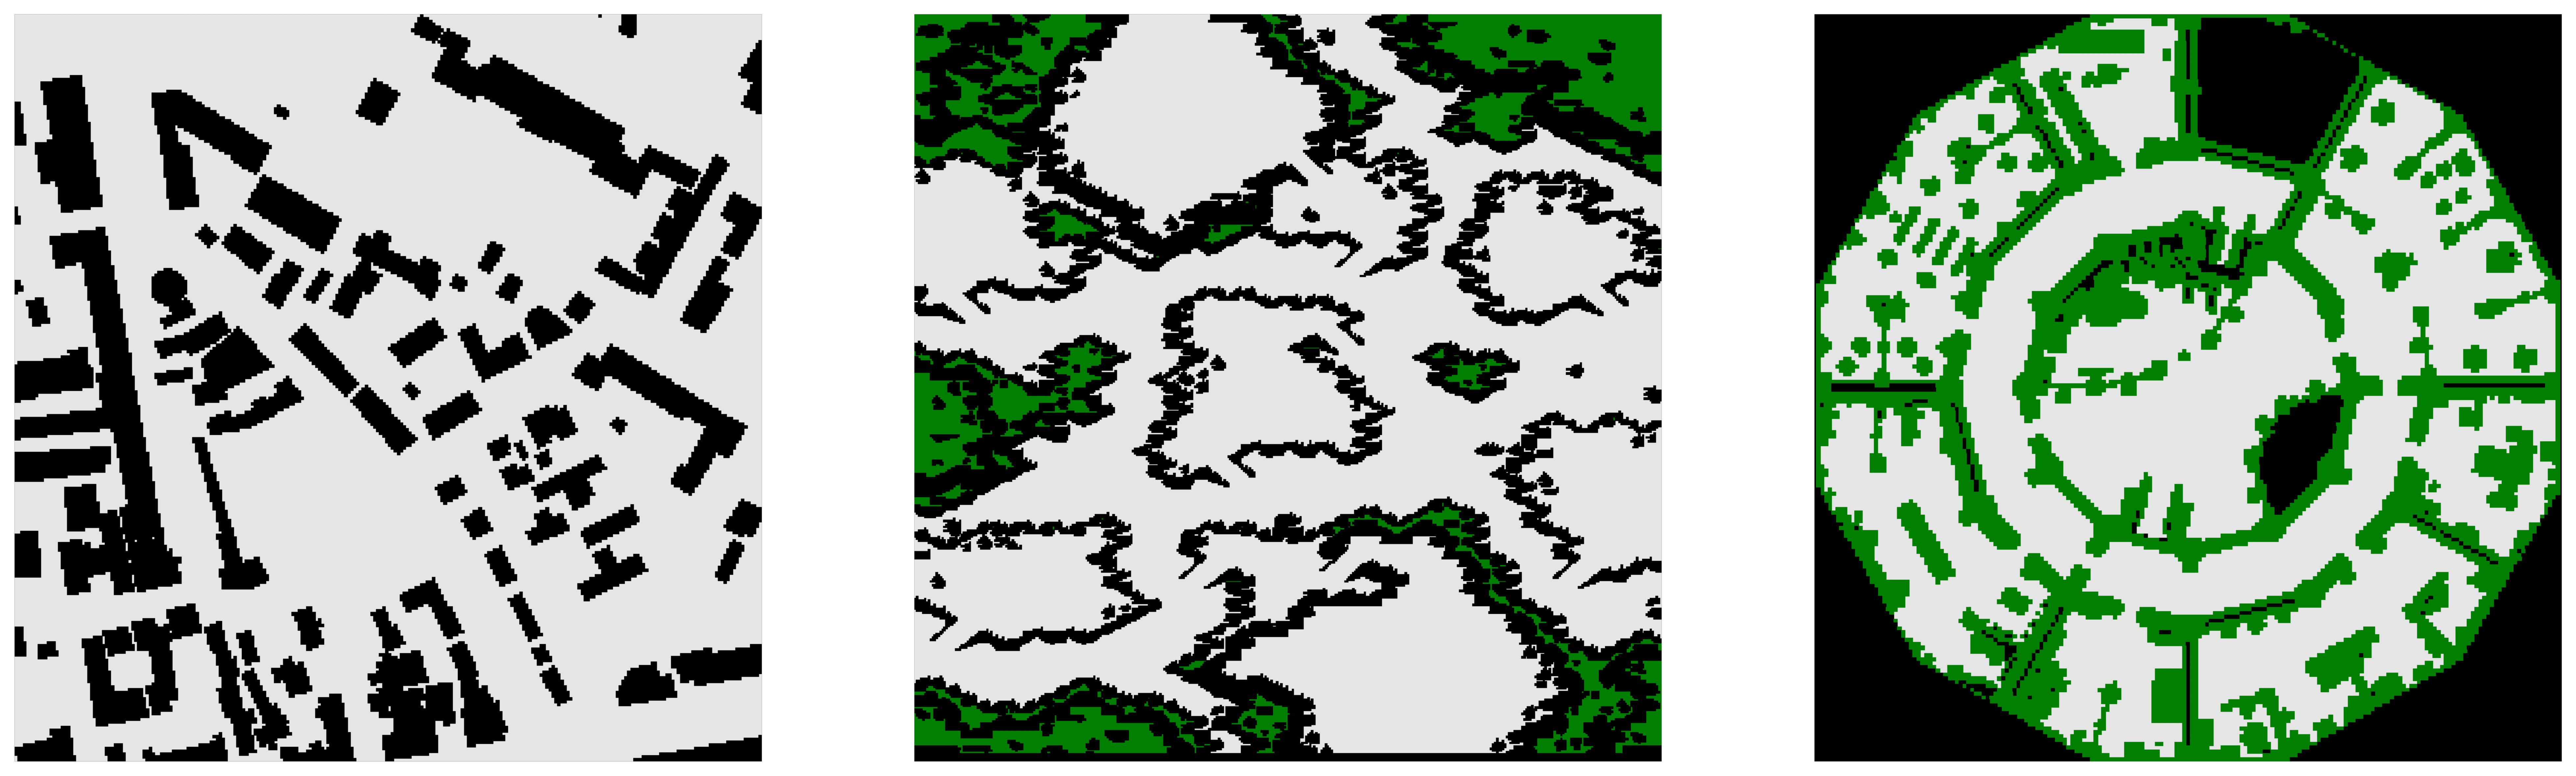

In [107]:
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 15), dpi=400)
ax[0].imshow(mpimg.imread(sep.join(["Москва", "Moscow_1_256.png"])))
ax[1].imshow(mpimg.imread(sep.join(["IceFloes из Starcraft", "IceFloes.png"])))
ax[2].imshow(mpimg.imread(sep.join(["lac304d из Dragon Age Origins", "lak304d.png"])))
for i in range(3): ax[i].axis("off")
plt.show()

Первая карта - городская - а именно, это карта части города Москва. Вторая карта - это карта IceFloes из игры Starcraft, она
интресна формой препятствий, которые образуют области, внутри которых можно находиться, но, чтобы их них выбраться, необходимо
найти выход из препятствий, которые как ограда окружают область. Третья карта - карта lac304d из игры Dragon Age: Origins, её 
форма напоминает круговой лабиринт - и чтобы дойти, например, от границы этого круга к его центру, нужно преодолеть множество
препятствий, образующих кольца вокруг центра.

Как можно заметить, все карты имеют совершенно разную топологию, благодаря чему наши тесты будут более объективными, а также
будут полезны не только для сравнения алгоритмов между собой, но и для сравнения эффективности одного алгоритма на разных картах.

В качестве вариантов алгоритма, которые мы будем тестировать, у нас будет WA* и A* без перераскрытий c диагональной эвристикой. Для WA* мы рассмотрим 5 различных значений фактора субоптимальности w: 1.05, 1.1, 1.5, 2, 5.

То есть всего у нас три набора по 100 задач для каждого из 6 вариантов алгоритма (5 штук WA* с различными w и один A*).

Сразу покажем результаты тестирования в виде диаграмм и графиков. Ознакомиться же с процессом их получения, а так же с самим 
процессом тестирования можно будет далее в коде.

Сразу заметим, что так как главная цель этой лабораторной заключается в том, чтобы сравнить WA\* между собой и с A\*, то все наши последующие графики и диаграммы будут строиться для значений, порлученных в ходе работы пяти алгоритмов WA\*, нормированных на соответсвующие значения A*. 

Для начала посмотрим на самую главную диаграмму, которая демонстрирует, для чего же нам нужен WA\*, чем он лучше A\*. Это диаграмма типа "ящик с усами", отражающий количество шагов всех пяти вариантов WA* на всех трёх картах (количество шагов представлено в виде процента от количества шагов обычного A* на этой же задаче). 

Заметим также, что количетсво шагов алгоритма (и WA\* и A\*) равно количеству раскрытых им вершин и пропорционально времени работы алгоритма. Так что эта диаграмма даёт нам представления и об этих характеристиках тоже.

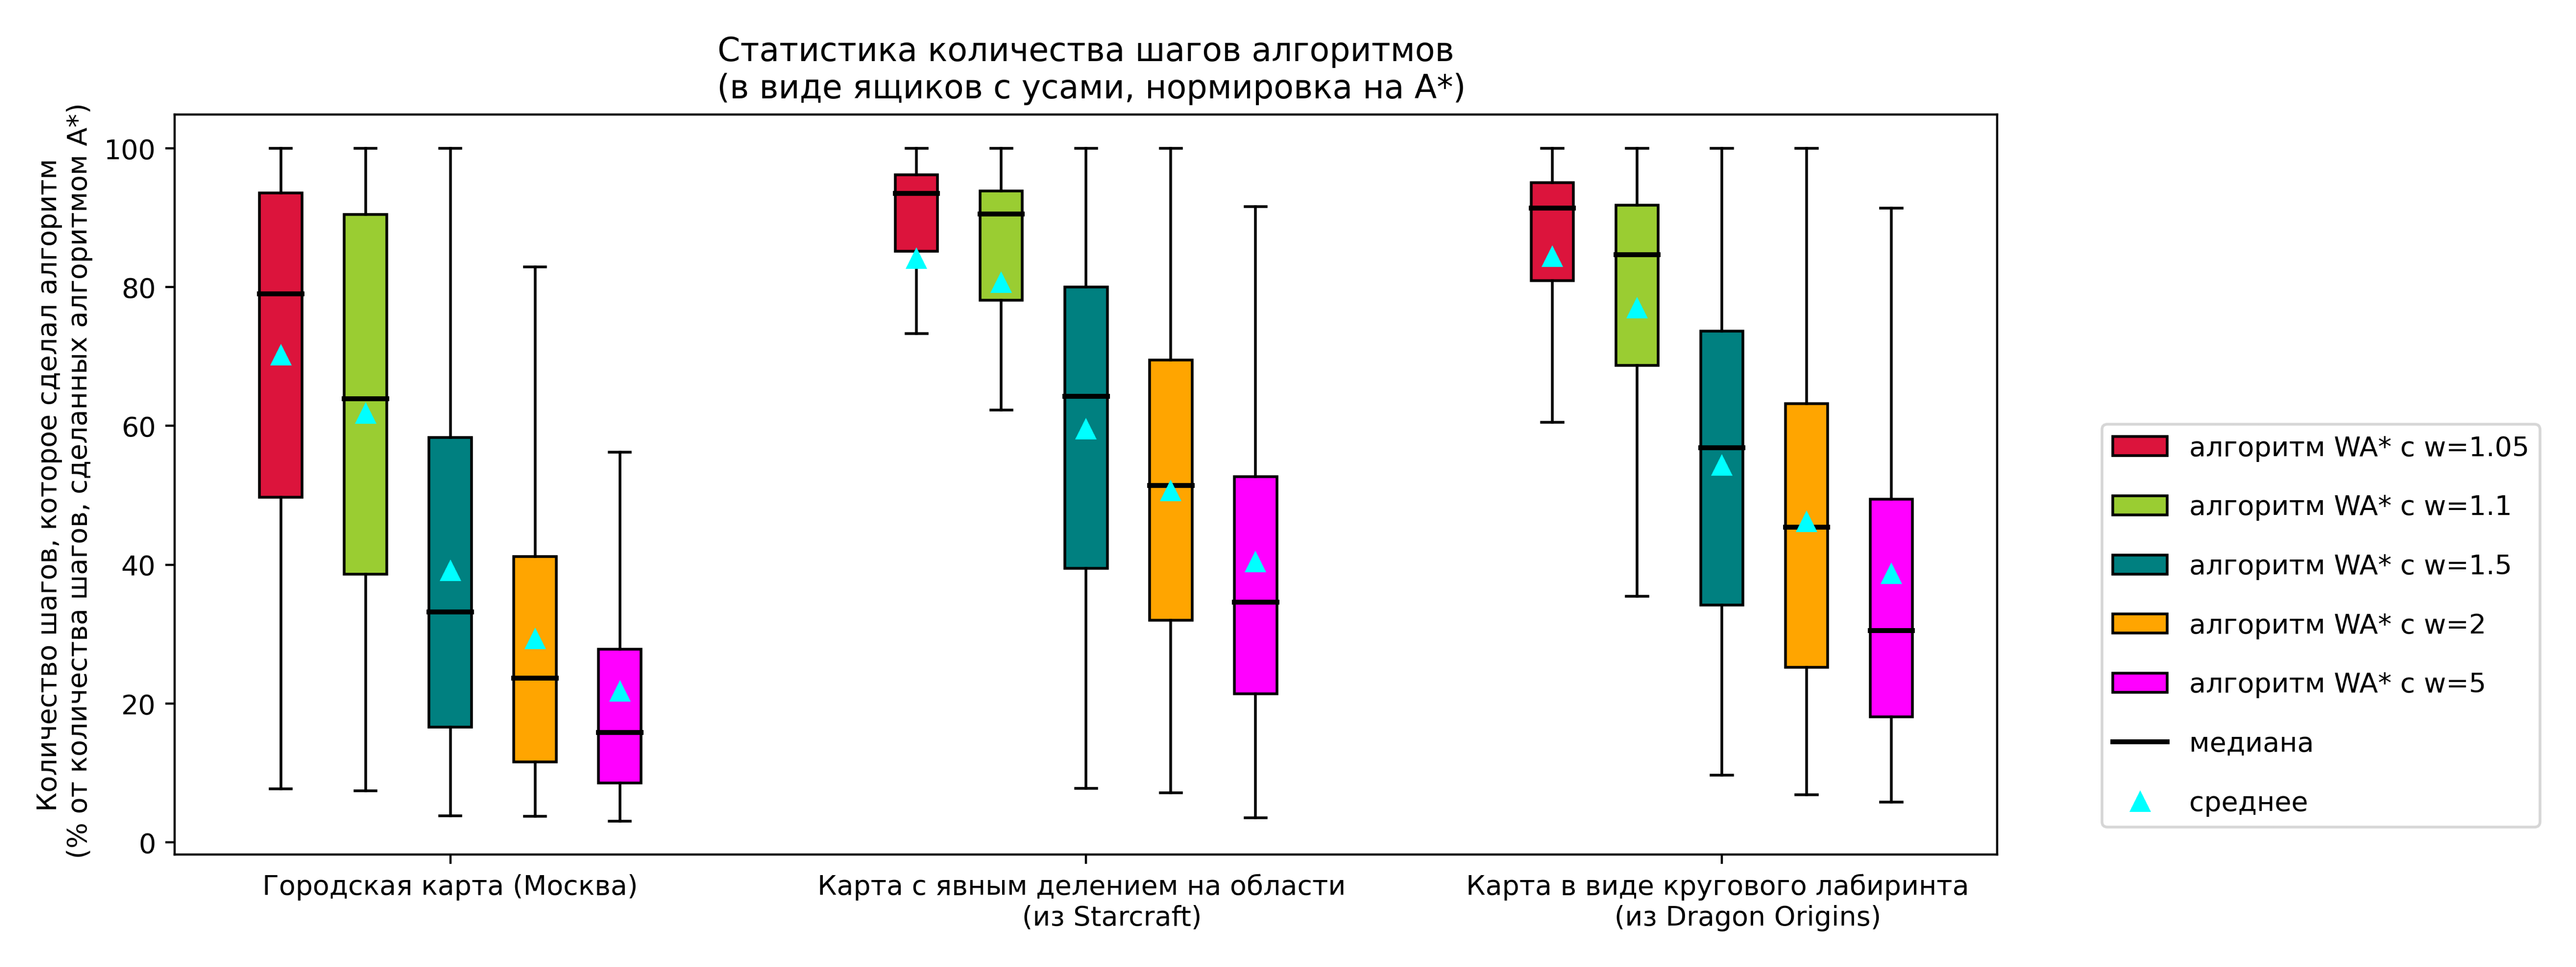

In [108]:
_, ax = plt.subplots(figsize=(20, 10), dpi=400)
plt.imshow(mpimg.imread(sep.join(["результаты", "boxplot_WA.png"])))
plt.axis("off")
plt.show()

Из диаграммы сразу видно, что на всех картах все алгоритмы WA\* работают быстрее, чем алгоритм A\* (так как значения статистики < 100%) - это с точностью до нескольких выбросов, которые мы не отображаем на этой диаграмме. Более того, при увеличении w (параметра субоптимальности) алгоритм WA* также начинает работать быстрее, причём значительно (это выражается в уменьшении сразу всех параметров статистики - и среднего, и медианы, и первой и третьей квартили!) - и опять же, это верно на всех картах.

То есть по этой диаграмме можно сделать вывод, что на любых картах алгоритм WA\* по времени оптимальнее, чем A\*. Более того, это разница может быть очень существенна - например, WA\* с w=5 на городской карте в среднем быстрее обычного A\* более, чем в 5 раз!!! И это именно тот результат, из-за которого нам нужен алгоритм WA\* - он даёт существенный прирост к скорости.

Это были общие наблюдения по всем картам. Теперь немного сравним результаты между собой. Во-первых, заметим, что самый большой прирост скорости WA* (для всех w) относительно A* наблюдается на городской карте - это вполне логично, так как препятствия там выглядят как прямоугольники (дома прямоугольной формы) и обойти их не очень сложно - поэтому небольшая переоценка эвристики в w раз как раз и учитывает необходимость немного обойти эти прямоугольники, чтобы дойти до целевой вершины. А вот на двух остальных картах препятствия имеют крайне сложную форму: образуют некий "забор" вокруг области (как в IceFloes) или круговой лабиринт (как из Dragon Origins), а потому домножения эвристики на w хоть и немного улучшают скорость, хоть как-то учитывая эти препятствия, но не так сильно, так как алгоритму все равно приходится долго плутать в поисках пути через эти препятствия. Во-вторых, можно заметить, что для WA* характерен очень большой разброс значений статистики - количества (точнее, доли относительно A*) сделанных шагов. Скорее всего это получается из-за большой разницы в тех тестах (сценариях), на которых мы запускаем эти алгоритмы. Например, у нас есть простые тесты, где до целевой вершины можно дойти почти по прямой за несколько шагов - в этом случае переоценка эвристики в w раз потчи никак не помогает ускорить алгоритм и поэтому значение статистики будет около 100%, а есть сложные тесты, где правильный выбор направления движения может сильно ускорить нахождение пути - и в таком случае значение статистики будет небольшим.

Итак, мы уже поняли, что WA* на всех картах даёт существенный прирост к скорости. Но теперь мы хотим узнать, чем же мы платим за это? Из теории мы знаем, что WA* с параметром субоптимальности w может находить путь, длиннее оптимального в <= w раз.

Посмотрим, как получается на самом деле, посмотрев на графики длины найденного пути (в % от длины оптимального пути (у нас A* всегда находит оптимальный путь, так что можно считать, что в % от длины пути, найденного A\*)) от количества шагов (снова нормирована на A\*). У нас будет три графика - для каждой карты свой.

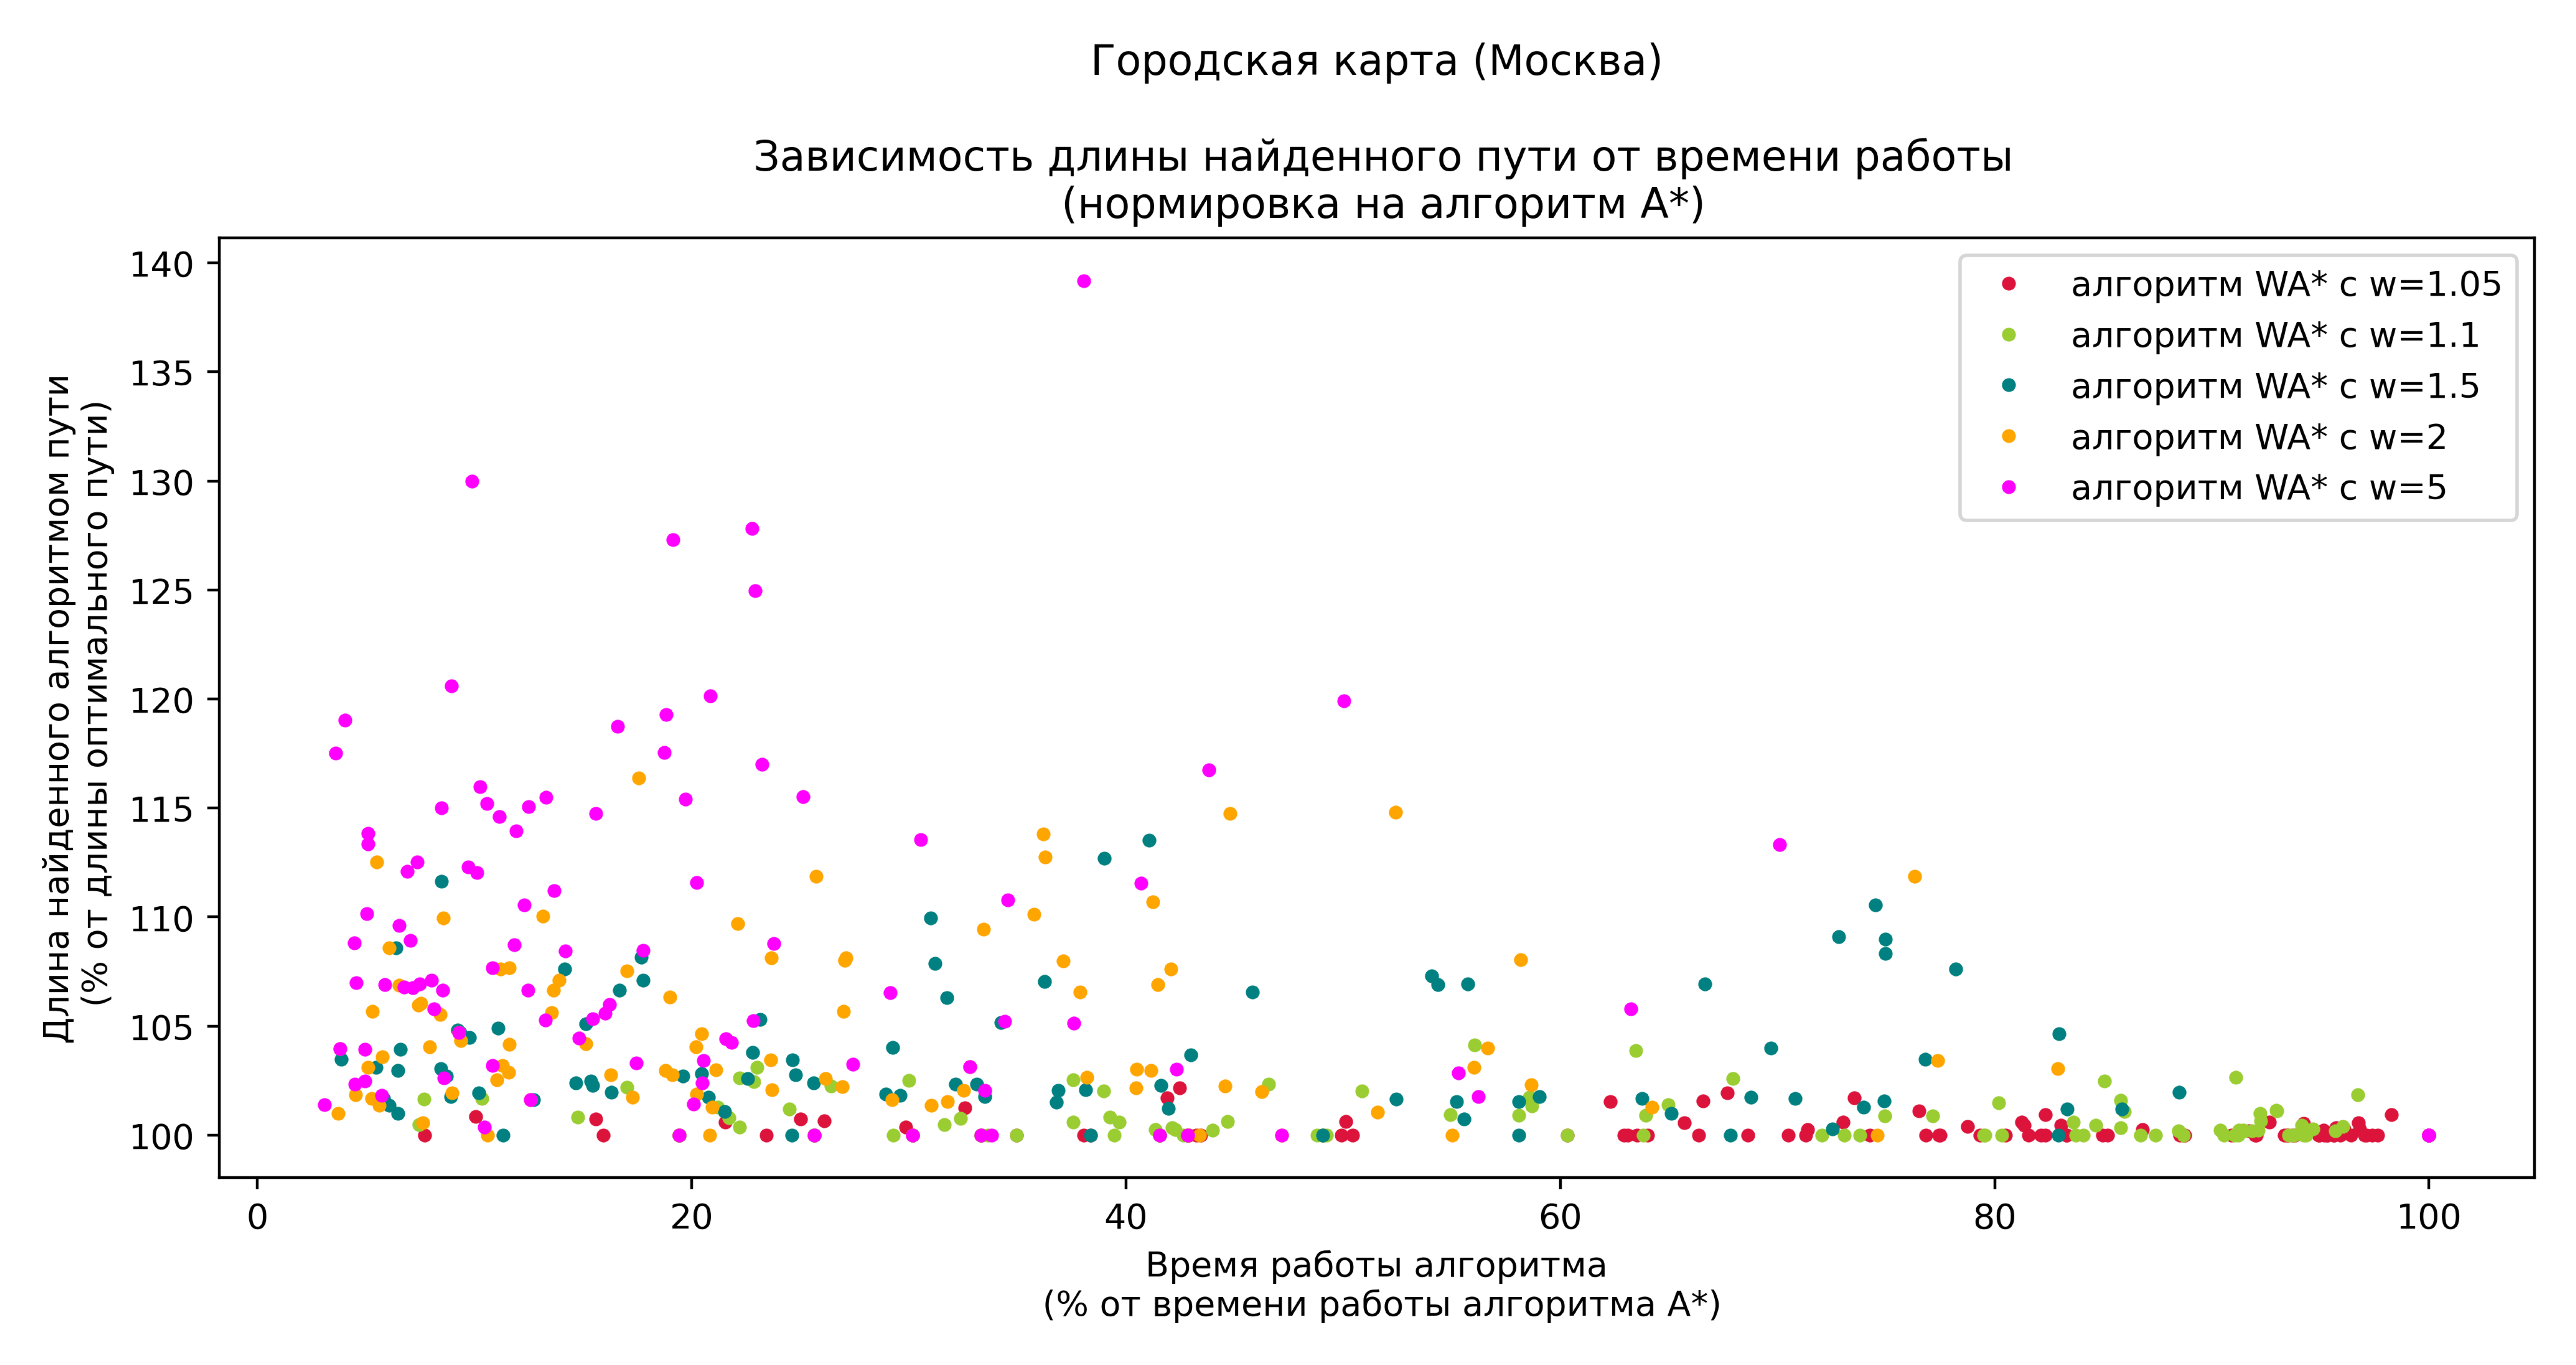

In [109]:
_, ax = plt.subplots(figsize=(20, 10), dpi=400)
plt.imshow(mpimg.imread(sep.join(["результаты", "msc_WA.png"])))
plt.axis("off")
plt.show()

Итак, тут у нас карта - городская.

Как видно из графика WA\* для небольших значений w (1.05 и 1.1) практически не переоценивает оптимальный путь (находит путь длины около 100% от длины оптимального пути (хотя выбранные w позволяют находить путь длины 105% и 110% соответственно)) - это связано с тем, что как мы уже говорили, для городской карты характерны небольшие прямоугольные препятствия, обход которых не сильно увеличивает длину пути - поэтому небольшие w как раз подходят, чтобы увеличить эвристику как раз аналогично увеличению пути из-за обхода препятсвий. Но при этом эти небольшие w дают неплохой выигрыш в скорости - как можно узнать из самого графика, но еще удобнее - из первой диаграммы: w=1.05 для городской карты даёт прирост к скорости в среднем на 20%, а w=1.1 даёт прирост к скорости в среднем на почти 40%! Очень хороший результат при условии, что мы не сильно увеличиваем длину пути (либо вообще не увеличиваем, либо на несколько процентов всего).

А вот для больших w (1.5, 2, 5) WA* уже довольно сильно переоценивает путь - получается аж до 25% переоценки для w=5 (не считая какие-то одтельные большие значения, похожие на выбросы), хотя это все равно гораздо меньше, чем разрешенная теоретически переоценка в 5 раз (500%). То есть относительно теоретически допустимой переоценки пути WA* даже для больших w работает очень неплохо с точки зрения длины найденного пути (а скорость увеличивается очень значильно - более, чем в 5 раз в среднем для w=5, как уже говорили на первой диаграмме). Опять же, это связано скорее всего с простотой самих препятствий на городской карте.

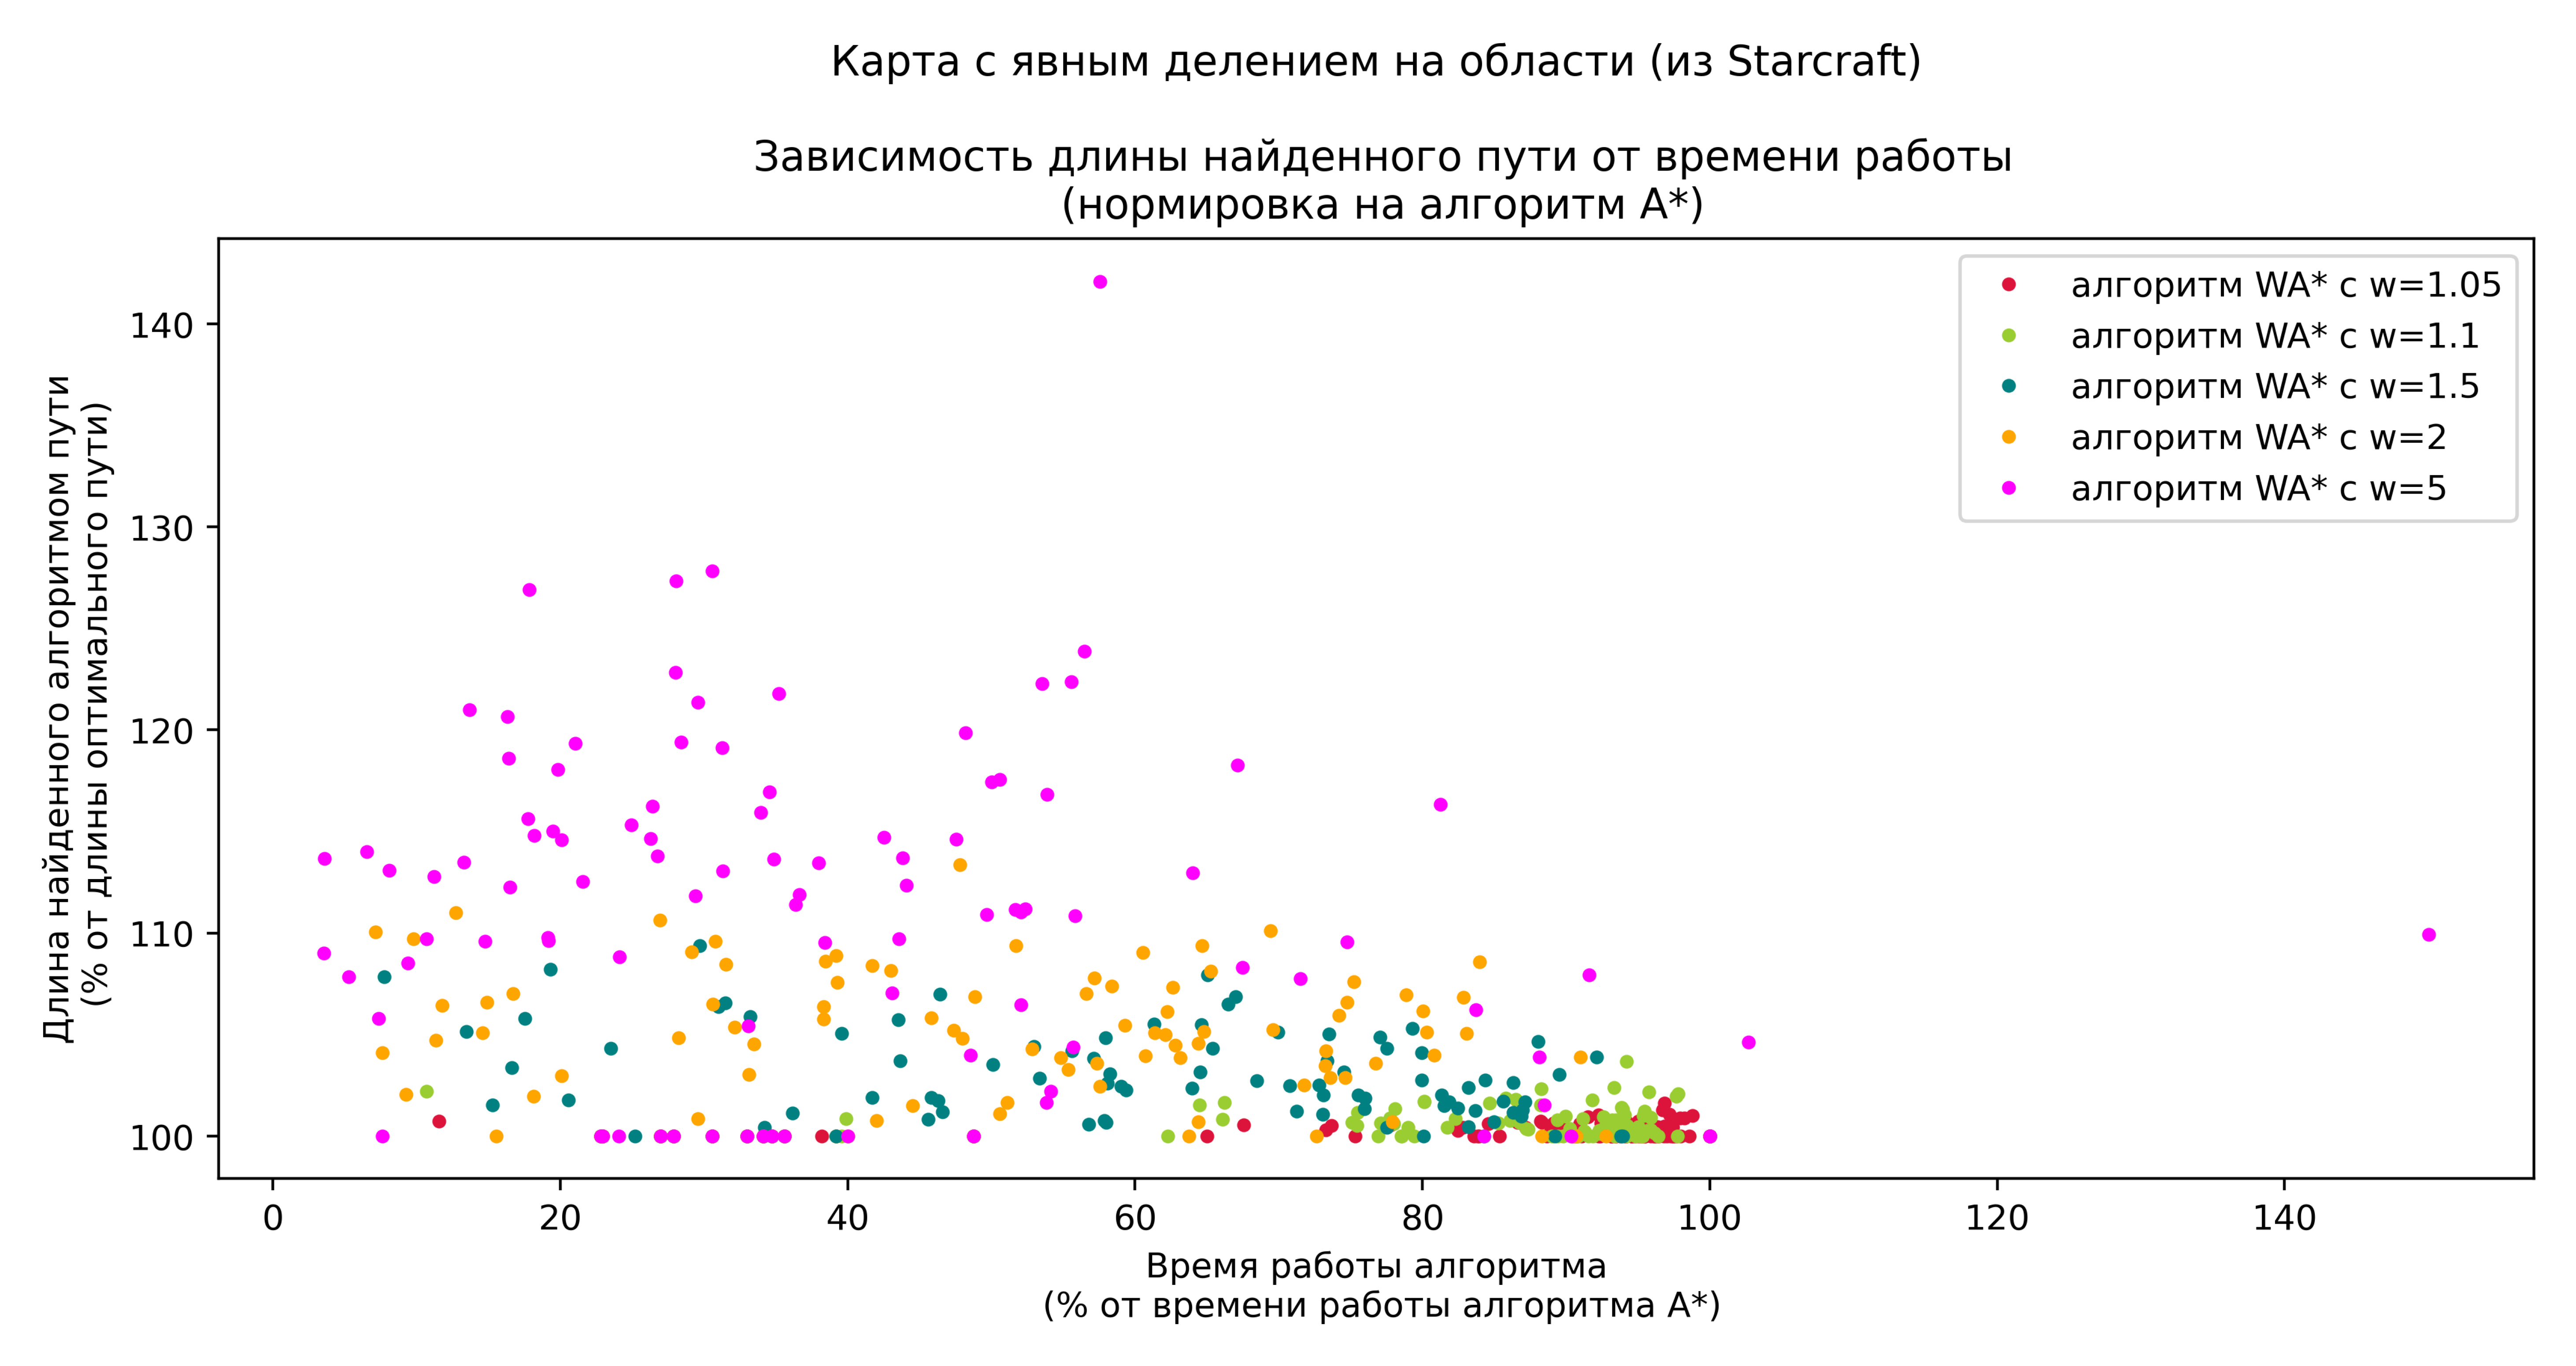

In [110]:
_, ax = plt.subplots(figsize=(20, 10), dpi=400)
plt.imshow(mpimg.imread(sep.join(["результаты", "starcraft_WA.png"])))
plt.axis("off")
plt.show()

Для карты с явным делением на области хорошо себя показывают WA* для w=1.05, 1.1, 1.5, 2 - довольно большое количество вариантов. 
Все эти варианты WA* переоценивают оптимальный путь не более, чем на 10% (кроме пары случаев с w=2) - и это очень хороший результат,
учитывая гигантский прирост скорости, который эти алгоритмы дают (например, исходя снова из первой диаграммы, WA* для w=2 на этой
карте даёт прирост к скорости (относительно обычно A\*) в 2 раза! а находит путь длиннее оптимального максимум на 10%, что совсем немного (опять же убеждаемся в высокой полезности WA\*). Так происходит потому, что на этой карте довольно сложные препятсвия, которые имеют форму забора с несколькими небольшими выходами - и часто нужно поплутать внутри забора, чтобы найти выход. И вот для таких сложных препятствий годятся довольно большие w, которые переоценивают эвристику достаточно сильно, чтобы 
сыметировать сложность поиска выхода из таких препятствий.

Также интересным явлением на этом графике являются два явных выброса для w=5. Один выброс переоценивает оптимальный путь более, чем на 40% (в принципе с теоретической точки зрения, это неплохой результат, так как разрешено переоценивать на <=500%, да и относительно того, что остальные случаи могут переоценивать путь на 30% - разница невелика, так что это можно не считать выбросом, но на графике выглядит одиноко), а второй выброс работает более, чем на 40% дольше обычного A\* - вот это уже странно, учитывая, что остальные случаи работают быстрее, чем A\*. Вероятнее всего так происходит в случае, когда мы находимся внутри некотрой области, ограниченной препятствием-забором, целевая позиция находится очень близко, но с другой стороны этого забора, а выход из этого забора находится в противоположном направлении от направления на целевую позицию. В таком случае большое значение w будет нас как бы "примагничивать" к целевой вершине, но мы не сможем в неё попасть, так как перед нами забор - и мы будем долго-долго идти в противоположную сторону до выхода из-за этого забора - это будет долго, так как большое значение w будет нас тянуть в другую сторону (ведь каждый шаг в противополжную от целевой позиции сторону будет с точки зрения нашей везвешенной эвристики стоить в 5 раз дороже, чем для обычного A*... - так что для алгоритма это будет "неохотно" и поэтому он будет долго работать, стараясь идти куда угодно, но не в строго противоположную сторону)

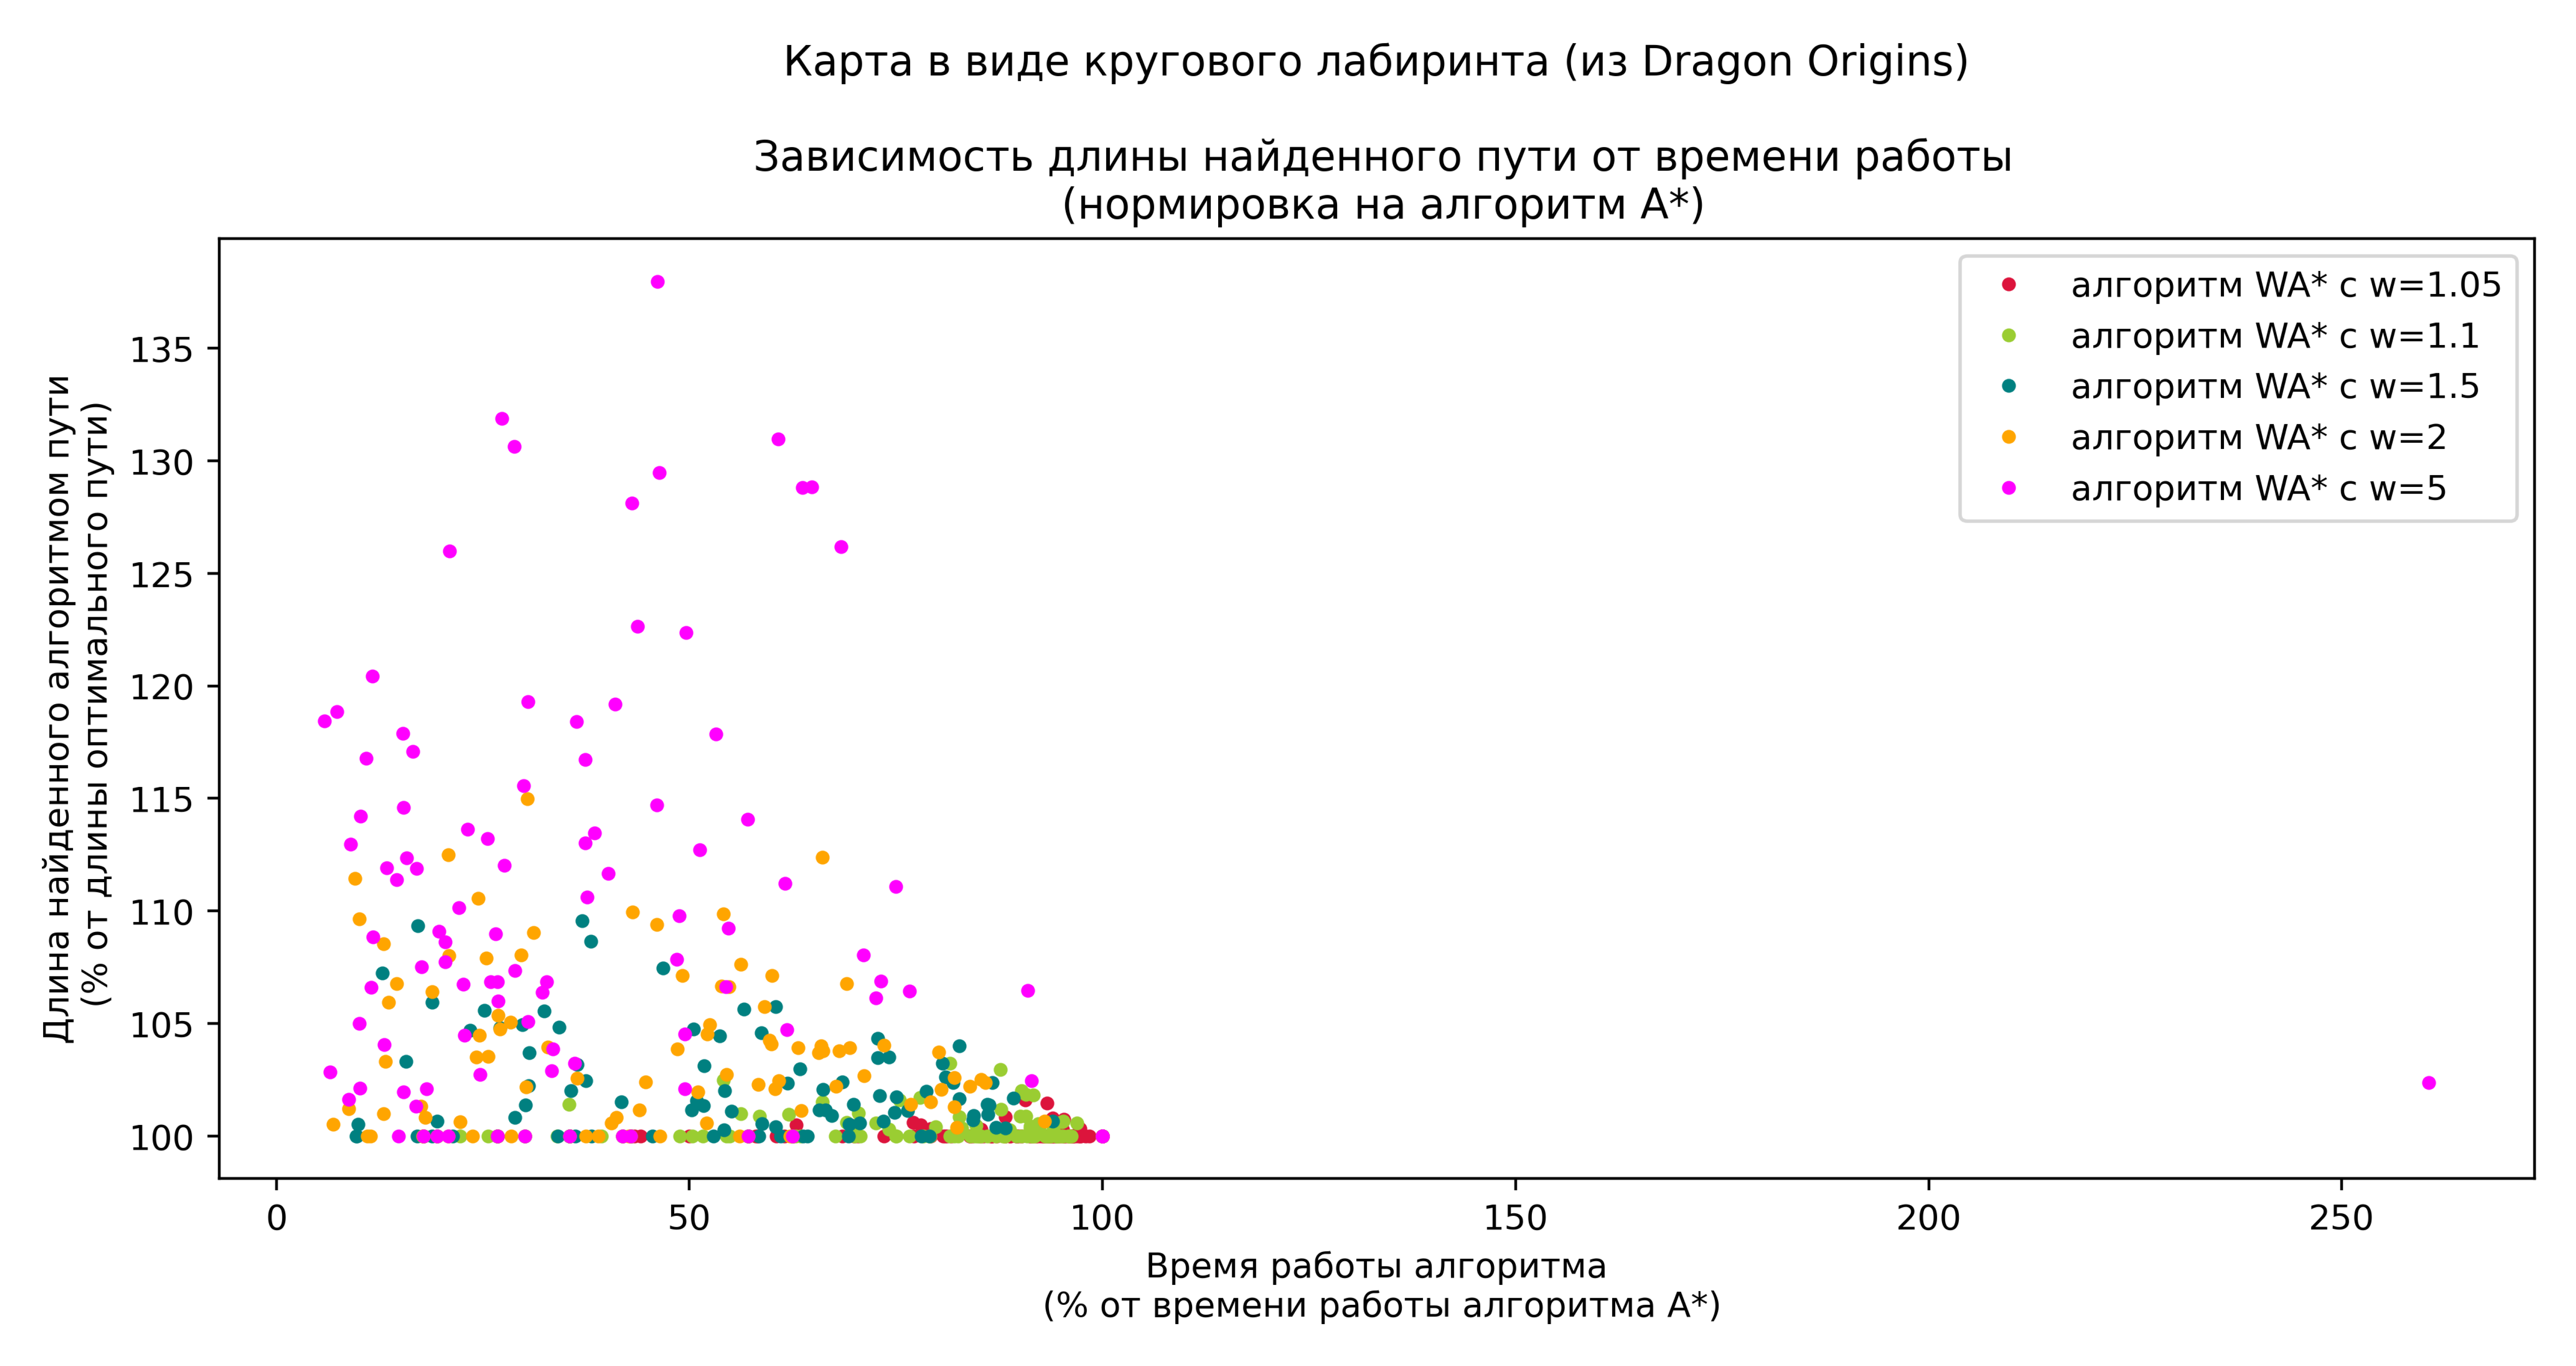

In [111]:
_, ax = plt.subplots(figsize=(20, 10), dpi=400)
plt.imshow(mpimg.imread(sep.join(["результаты", "dragon_WA.png"])))
plt.axis("off")
plt.show()

Здесь у нас карта в виде кругового лабиринта.

Для этого графика в принципе справедливо всё то же, что было сказано для предыдущего графика. Опять же сложные препятствия, которые долго обходить, позволяют использовать большие w=1.05, 1.1, 1.5, 2 и получать переоценку пути очень маленькую в сравнении с теоретически допустимой (например, для w=1.05 теоретически допускается переоценивание оптимального пути на 5%, но судя по графику WA*  с этим значеннием w переоценивает оптимальный путь не более, чем на процент; для w=1.5 допускается переоценивание на 50%, а у нас не более 10%). 

Здесь также есть выброс, но гораздо более значительный, чем на предыдущем графике. На некотором тесте WA* с w=5 работал более, чем в 2.5 раза дольше, чем обычный A*! Причина здесь скорее всего примерно такая же, как на предыдущем графике. Начальная и целевая вершина оказались рядом (с точки зрения пути "по воздуху"), но между ними оказалось несколько стенок кругового лабиринта. И в этом случае большое значение w тянет алгоритм в сторону целевой вершины, но для того, чтобы её достичь нам нужно сначала обойти лабиринт по кругу, двигаясь в другую от целевой вершины сторону (что наша взвешенная эвристика оценивает как неоптимальное движение с большим весом), найти выход из текущей секции лабиринта, а потом аналогично найти выход и из следующих секций. И всё это нужно делать, двигаясь в направлениях, которые эвристика считает не самыми лучшими. Вообще для лабиринтов весьма характерно, что часто, чтобы найти выход, нужно двигатся в противоположную от выхода сторону - это и для человека не очень удобно, а для эвристики тем более.

**Вывод**

На любых картах в большинстве ситуаций WA* даёт значительный выигрыш во времени относительно обычного A\*. При этом чем больше w (параметр субоптимальности), тем быстрее в среднем работает WA\* на большинстве карт, поэтому по возможности стоит брать w побольше.

Но если мы хотим получить путь, не сильно длиннее оптимального, не стоит брать слишком большие значения w. Для городских карт лучше выбирать не очень большие значения w (брать, например w=1.05 и 1.1) - в таком случае найденный путь почти не будет отличаться от оптимального, а выигрыш во времени может составить даже 40% относительно A*. Для более сложной топологии можно брать значения побольше (w=1.5, 2, 5)

Также нужно быть осторожным с картами, имеющими вид лабиринта - то есть когда есть близко расположенные в пространтсве проходы, но разделенные стеной, чтобы обойти которую нужно потратить довольно много времени на поиск этого обхода. На таких картах не стоит брать большие w, иначе вместо прироста скорости можем получить значительное замедленее.

Далее уже идёт код.

-*-*--------------------------------------------------------------------------------------------------------------------------------------------------------------

In [1]:
class Map:

    def __init__(self):
        '''
        Default constructor
        '''

        self._width = 0
        self._height = 0
        self._cells = []
    

    def read_from_string(self, cell_str, width, height):
        '''
        Converting a string (with '#' representing obstacles and '.' representing free cells) to a grid
        '''
        self._width = width
        self._height = height
        self._cells = [[0 for _ in range(width)] for _ in range(height)]
        cell_lines = cell_str.split("\n")
        i = 0
        j = 0
        for l in cell_lines:
            if len(l) != 0:
                j = 0
                for c in l:
                    if c == '.':
                        self._cells[i][j] = 0
                    elif c == '#':
                        self._cells[i][j] = 1
                    else:
                        continue
                    j += 1
                if j != width:
                    raise Exception("Size Error. Map width = ", j, ", but must be", width )
                
                i += 1

        if i != height:
            raise Exception("Size Error. Map height = ", i, ", but must be", height )
    
     
    def set_grid_cells(self, width, height, grid_cells):
        '''
        Initialization of map by list of cells.
        '''
        self._width = width
        self._height = height
        self._cells = grid_cells


    def in_bounds(self, i, j):
        '''
        Check if the cell is on a grid.
        '''
        return (0 <= j < self._width) and (0 <= i < self._height)
    

    def traversable(self, i, j):
        '''
        Check if the cell is not an obstacle.
        '''
        return not self._cells[i][j]
    
    
    def not_break_corner(self, curr_i, curr_j, destination_i, destination_j):  # функция, проверяющая, что переходом из (curr_i, curr_j) в (destination_i, destination_j) мы не срезаем углы.
        if abs(curr_i - destination_i) + abs(curr_j - destination_j) == 1:  # если это кардинальный ход (те вверх, вниз, вправо, влево), то никаких углов мы срезать не можем вообще, так как не ходим через угол
            return True
        else: # если ход по диагонали
            return (self.traversable(curr_i, destination_j)) and (self.traversable(destination_i, curr_j))  # выдаём, правда ли, что не срезаем углы
        # кстати, беспокоиться, что какая-то координата тут вне нашего поля - не нужно, ведь эту функцию мы возовем после проверки, 
        # что (destination_i, destination_j) лежит в поле и свободная - а тк сравнение в питоне ленивое, то если что-то из таких сравнений не выполнится, то этой функции питон не дойдёт
        

    def get_neighbors(self, i, j):
        neighbors = []
        delta = [[0, 1], [1, 0], [0, -1], [-1, 0], [1, 1], [1, -1], [-1, 1], [-1, -1]]  # наши 8 возможных смещений за один ход

        for d in delta:
            if self.in_bounds(i + d[0], j + d[1]) and self.traversable(i + d[0], j + d[1]) and self.not_break_corner(i, j, i + d[0], j + d[1]):
                neighbors.append((i + d[0], j + d[1]))
        return neighbors

    def get_size(self):
        return (self._height, self._width)

In [2]:
def compute_cost(i1, j1, i2, j2):
    if abs(i1 - i2) + abs(j1 - j2) == 1: # если кардинальный ход, то его тоимость 1
        return 1
    elif abs(i1 - i2) + abs(j1 - j2) == 2:  # если диагональный ход, то его стоимость sqrt(2) - длина диагонли
        return math.sqrt(2)
    else:
        raise Exception('Поптыка посчитать стоимость недоступного хода. Возможны лишь кардинальные и диагональные ходы')

In [114]:
class Node:
    '''
    Node class represents a search node

    - i, j: coordinates of corresponding grid element
    - g: g-value of the node
    - h: h-value of the node // always 0 for Dijkstra
    - F: f-value of the node // always equal to g-value for Dijkstra
    - parent: pointer to the parent-node 

    '''
    

    def __init__(self, i, j, g = 0, h = 0, f = None, parent = None, tie_breaking_func = None):
        self.i = i
        self.j = j
        self.g = g
        self.h = h
        if f is None:
            self.f = self.g + h
        else:
            self.f = f        
        self.parent = parent

        
    
    def __eq__(self, other):
        '''
        Estimating where the two search nodes are the same,
        which is needed to detect dublicates in the search tree.
        '''
        return (self.i == other.i) and (self.j == other.j)
    
    def __hash__(self):
        '''
        To implement CLOSED as set of nodes we need Node to be hashable.
        '''
        ij = self.i, self.j
        return hash(ij)


    def __lt__(self, other): 
        '''
        Comparing the keys (i.e. the f-values) of two nodes,
        which is needed to sort/extract the best element from OPEN.
        
        This comparator is very basic. We will code a more plausible comparator further on.
        '''
        return self.f < other.f

In [115]:
class SearchTreePQS:
    
    def __init__(self):
        self._open = []      
        self._closed = set()      
        self._enc_open_dublicates = 0
        
    def __len__(self):
        return len(self._open) + len(self._closed)
                    
    def open_is_empty(self):
        return len(self._open) == 0
     
    def add_to_open(self, item):  
        heapq.heappush(self._open, item)
        return
    
    def get_best_node_from_open(self):
        best = None
        while(True):
            best = heapq.heappop(self._open)  
            if (not self.was_expanded(best)): break
            if len(self._open) == 0: return None
        return best    

    def add_to_closed(self, item):
        self._closed.add(item)

    def was_expanded(self, item):
        return item in self._closed

    @property
    def OPEN(self):
        return self._open
    
    @property
    def CLOSED(self):
        return self._closed

    @property
    def number_of_open_dublicates(self):
        return self._enc_open_dublicates

Далее определяем функцию диагональной метрики, для которой будем тестировать алгоритм WA* и A*:

In [116]:
def octile_distance(i1, j1, i2, j2):  # Диагональная метрика
    delta_x = abs(i1 - i2)
    delta_y = abs(j1 - j2)
    return math.sqrt(2) * min(delta_x, delta_y) + abs(delta_x - delta_y)

Далее обычный алгоритм A*:

In [117]:
def astar(grid_map, start_i, start_j, goal_i, goal_j, heuristic_func = None, search_tree = None):
    ast = search_tree()
    steps = 0
    nodes_created = 0
    CLOSED = None

    start = Node(start_i, start_j, f = 0, h=heuristic_func(start_i, start_j, goal_i, goal_j))
    nodes_created += 1 
    ast.add_to_open(start)
        
    while (not ast.open_is_empty()):
        steps += 1
        
        curr_node = ast.get_best_node_from_open() 
        if curr_node is None: break
        ast.add_to_closed(curr_node)
        
        if ((curr_node.i == goal_i) and (curr_node.j == goal_j)):
            OPEN = ast.OPEN
            CLOSED = ast.CLOSED
            return (True, curr_node, steps, nodes_created, OPEN, CLOSED)
        
        for i, j in grid_map.get_neighbors(curr_node.i, curr_node.j):  
            transfer_cost = compute_cost(i1=curr_node.i, j1=curr_node.j, i2=i, j2=j) 
            succesor = Node(i=i, j=j, g=curr_node.g + transfer_cost, parent = curr_node, h=heuristic_func(i, j, goal_i, goal_j))
            nodes_created += 1
            
            if (not ast.was_expanded(item=succesor)):  
                ast.add_to_open(succesor)   

    CLOSED = ast.CLOSED
    return False, None, steps, nodes_created, None, CLOSED

А теперь код алгоритма WA*:

In [3]:
def w_astar(w, grid_map, start_i, start_j, goal_i, goal_j, heuristic_func = None, search_tree = None):
    ast = search_tree()
    steps = 0
    nodes_created = 0
    CLOSED = None

    start = Node(start_i, start_j, f = 0, h=heuristic_func(start_i, start_j, goal_i, goal_j))
    nodes_created += 1 
    ast.add_to_open(start)
        
    while (not ast.open_is_empty()):
        steps += 1
        
        curr_node = ast.get_best_node_from_open() 
        if curr_node is None: break
        ast.add_to_closed(curr_node)
        
        if ((curr_node.i == goal_i) and (curr_node.j == goal_j)):
            OPEN = ast.OPEN
            CLOSED = ast.CLOSED
            return (True, curr_node, steps, nodes_created, OPEN, CLOSED)
        
        for i, j in grid_map.get_neighbors(curr_node.i, curr_node.j):  
            transfer_cost = compute_cost(i1=curr_node.i, j1=curr_node.j, i2=i, j2=j) 
            succesor = Node(i=i, j=j, g=curr_node.g + transfer_cost, parent = curr_node, h=w * heuristic_func(i, j, goal_i, goal_j))  # просто эвристика домножиласть на w
            nodes_created += 1
            
            if (not ast.was_expanded(item=succesor)):  
                ast.add_to_open(succesor)   

    CLOSED = ast.CLOSED
    return False, None, steps, nodes_created, None, CLOSED

Функции для чтения карты и сценариев:

In [119]:
def read_map_from_file(path):  # читаем карту из файла и возвращаем эту карту в виде объекста нашего класса Map
    map_file = open(path)
    _ = map_file.readline()
    height = int(map_file.readline().split()[1])
    width = int(map_file.readline().split()[1])
    _ = map_file.readline()
    cells = [[0 for _ in range(width)] for _ in range(height)]
    
    i = 0
    j = 0
    for line in map_file:
        j = 0
        for symbol in line:
            if symbol == '.' or symbol == 'G':
                cells[i][j] = 0
            else:
                cells[i][j] = 1
                
            j += 1
            if j == width: break
                
        i += 1
        if i == height: break
            
    map_file.close()
    read_map = Map()
    read_map.set_grid_cells(width, height, cells)
   
    return read_map

In [120]:
def read_scenarios_from_file(path, need_scenes):  # из файла равномерно читаем need_scenes сценариев
    scen_file = open(path)
    _ = scen_file.readline()
    
    scenarios = []
    for line in scen_file:
        columns = line.split("\t")[-5:]
        scenarios.append(list(map(int, columns[:-1])) + [float(columns[-1])])
    scen_file.close()
    
    num_all_scenes = len(scenarios)
    if num_all_scenes <= need_scenes: 
        complete_scenes = scenarios
    elif need_scenes == 1:
        complete_scenes = [scenarios[0]]
    else:
        step = (num_all_scenes - 1) / (need_scenes - 1)
        complete_scenes = []
        for i in range(need_scenes):
            complete_scenes.append(scenarios[round(step * i)])
            
    return complete_scenes
    

Вводим предварительные данные для тестирования

In [121]:
n = 100  # число сценариев для каждой карты
eps = 1e-5  # число, на сколько могут отличаться float значения, чтобы мы считали их равными (это для сравнений длин кратчайших путей)

In [122]:
# Три карты и по n=100 сценариев для каждой из них
num_maps = 3  # число карт

moscow_map = read_map_from_file(sep.join(["Москва", "Moscow_1_256.map"]))  # считываем карту
moscow_scenes = read_scenarios_from_file(sep.join(["Москва", "Moscow_1_256.map.scen"]), n)  # и n сценариев к ней

icefloes_map = read_map_from_file(sep.join(["IceFloes из Starcraft", "IceFloes.map"]))
icefloes_scenes = read_scenarios_from_file(sep.join(["IceFloes из Starcraft", "IceFloes.map.scen"]), n)

dragon_map = read_map_from_file(sep.join(["lac304d из Dragon Age Origins", "lak304d.map"]))
dragon_scenes = read_scenarios_from_file(sep.join(["lac304d из Dragon Age Origins", "lak304d.map.scen"]), n)

tests_map = [moscow_map, icefloes_map, dragon_map]  # собираем все в массив
tests_scene = [moscow_scenes, icefloes_scenes, dragon_scenes]

In [123]:
"""
Для каждого из 6 алгоритмов (обычный A* и WA* для пяти факторов субоптимальности w = 1.05, 1.1, 1.5, 2, 5) заводим по два
массива: steps и find_length. Оба массива в свою очередь содержат массивы для с результатами для каждой из карт.

В массиве steps хранится количество шагов алгоритма, которые он сделал для нахождения пути, а в массиве find_length хранится
длина найденного алгоритмом пути (для A* это будет, конечно, длина наикратчайшего пути (ведь эвристика octile distance
допустимая, а значит A* (без перераскрытий как у нас) находит обязательно оптимальный путь), а вот для WA* с фактором 
суботимальности w эта длина может быть немного больше, чем длина наикратчайшего пути (но так как эвристика octile_distance - 
монотонная, то WA* (без перераскрытий как у нас) обязательно находит путь, не длиннее, чем в w раз, чем оптимальный путь))

Каждый массив steps хранит num_maps массивов для каждой карты, и в каждом таком массиве хранится n (число сценариев) чисел
- количетсв шагов алгоритма на каждом из n сценариев для данной карты. Для find_length аналогично. Таким образом, мы храним
данные для всех трех карт по отдельности.
"""

WA_w105_steps = [[] for _ in range(num_maps)]
WA_w110_steps = [[] for _ in range(num_maps)]
WA_w150_steps = [[] for _ in range(num_maps)]  # например, это массив steps для WA* с w=1.5
WA_w200_steps = [[] for _ in range(num_maps)]
WA_w500_steps = [[] for _ in range(num_maps)]
A_steps = [[] for _ in range(num_maps)]

WA_w105_find_length = [[] for _ in range(num_maps)]
WA_w110_find_length = [[] for _ in range(num_maps)]
WA_w150_find_length = [[] for _ in range(num_maps)]
WA_w200_find_length = [[] for _ in range(num_maps)]
WA_w500_find_length = [[] for _ in range(num_maps)]
A_find_length = [[] for _ in range(num_maps)]

In [124]:
# собираем всё для каждой метрики в массив  
all_steps = [WA_w105_steps, WA_w110_steps, WA_w150_steps, WA_w200_steps, WA_w500_steps, A_steps]
all_find_length = [WA_w105_find_length, WA_w110_find_length, WA_w150_find_length, 
                   WA_w200_find_length, WA_w500_find_length, A_find_length]
# соответственно для каждого из 6 вариантов алгоритмов устанавливаем значение w (для обычного A* его нет - пишем None):
w_param = [1.05, 1.1, 1.5, 2, 5, None]

Наконец начинаем тестировать:

In [ ]:
for steps, find_length, w in zip(all_steps, all_find_length, w_param):
    for test_map, test_scene, num_map in zip(tests_map, tests_scene, range(num_maps)):
        for scene in test_scene:
            start_j = scene[0]  # ВАЖНО!!! у нас i - это координата по выосте (те номер строки), а j - координата по горизонтали!
            start_i = scene[1]  # а в сценарии первой идёт координата x (координата по горизонтали), а потом y (по вертикали)
            goal_j = scene[2]  # поэтому читаем только так! - сначала j координата (start_j), затем i (start_i)
            goal_i = scene[3]  # на этом была долго ошибка, которую сложно было найти...
            
            true_length_of_path = scene[4]  # настоящая длина оптимального (кратчайшего) пути, с которой нам нужно сверить
            
            if w is not None:  # если есть параметр w, то запускаем WA*
                find_path, last_node, num_steps, _, _, _ = w_astar(w, test_map, start_i, start_j, goal_i, 
                                                                    goal_j, heuristic_func=octile_distance, 
                                                                    search_tree=SearchTreePQS)  # берём три нужных нам результата работы алгоритма
                length_find_path = last_node.g  # длина найденного пути - это g-значение последней (конечной вершины)
            else:  # если нет w, значит это обычный A*:
                find_path, last_node, num_steps, _, _, _ = astar(test_map, start_i, start_j, goal_i, 
                                                                 goal_j, heuristic_func=octile_distance, 
                                                                 search_tree=SearchTreePQS)
                length_find_path = last_node.g
                
            if find_path:  # если путь алгоритм нашёл
                if w is not None:  # если мы сейчас WA* тестируем:
                    assert(length_find_path <= true_length_of_path * w + eps)  # проверяем, что алгоритм WA* корректно работает - то есть находит путь длины не больше, чем в w раз, чем оптимальный (с точностью до сравнения float чисел - те до eps) 
                else:  # если сейчас A* тестируем:
                    assert(abs(length_find_path - true_length_of_path) < eps)  # проверяем, что A* корректно работает - то есть находит оптимальный путь (путь с кратчайшей длинной)  - эти assert нужны просто, чтобы убедиться, что правильно написан код для алгоритмов astar и w_astar
                steps[num_map].append(num_steps)  # число шагов алгоритма (оно равно числу раскрытий вершин, а также пропорционально времени работы алгоритма)
                find_length[num_map].append(length_find_path)
            else:
                raise Exception("Что-то не так")  # если путь не нашли, то выдаём исключение, ведь во всех наших тестах путь точно есть 

Теперь отобразим результаты в симпатичном виде

In [126]:
# но для начала для удобства все наши массивы переделаем в numpy
WA_w105_steps = np.array(WA_w105_steps)
WA_w110_steps = np.array(WA_w110_steps)
WA_w150_steps = np.array(WA_w150_steps)
WA_w200_steps = np.array(WA_w200_steps)
WA_w500_steps = np.array(WA_w500_steps)
A_steps = np.array(A_steps)

WA_w105_find_length = np.array(WA_w105_find_length)
WA_w110_find_length = np.array(WA_w110_find_length)
WA_w150_find_length = np.array(WA_w150_find_length)
WA_w200_find_length = np.array(WA_w200_find_length)
WA_w500_find_length = np.array(WA_w500_find_length)
A_find_length = np.array(A_find_length)

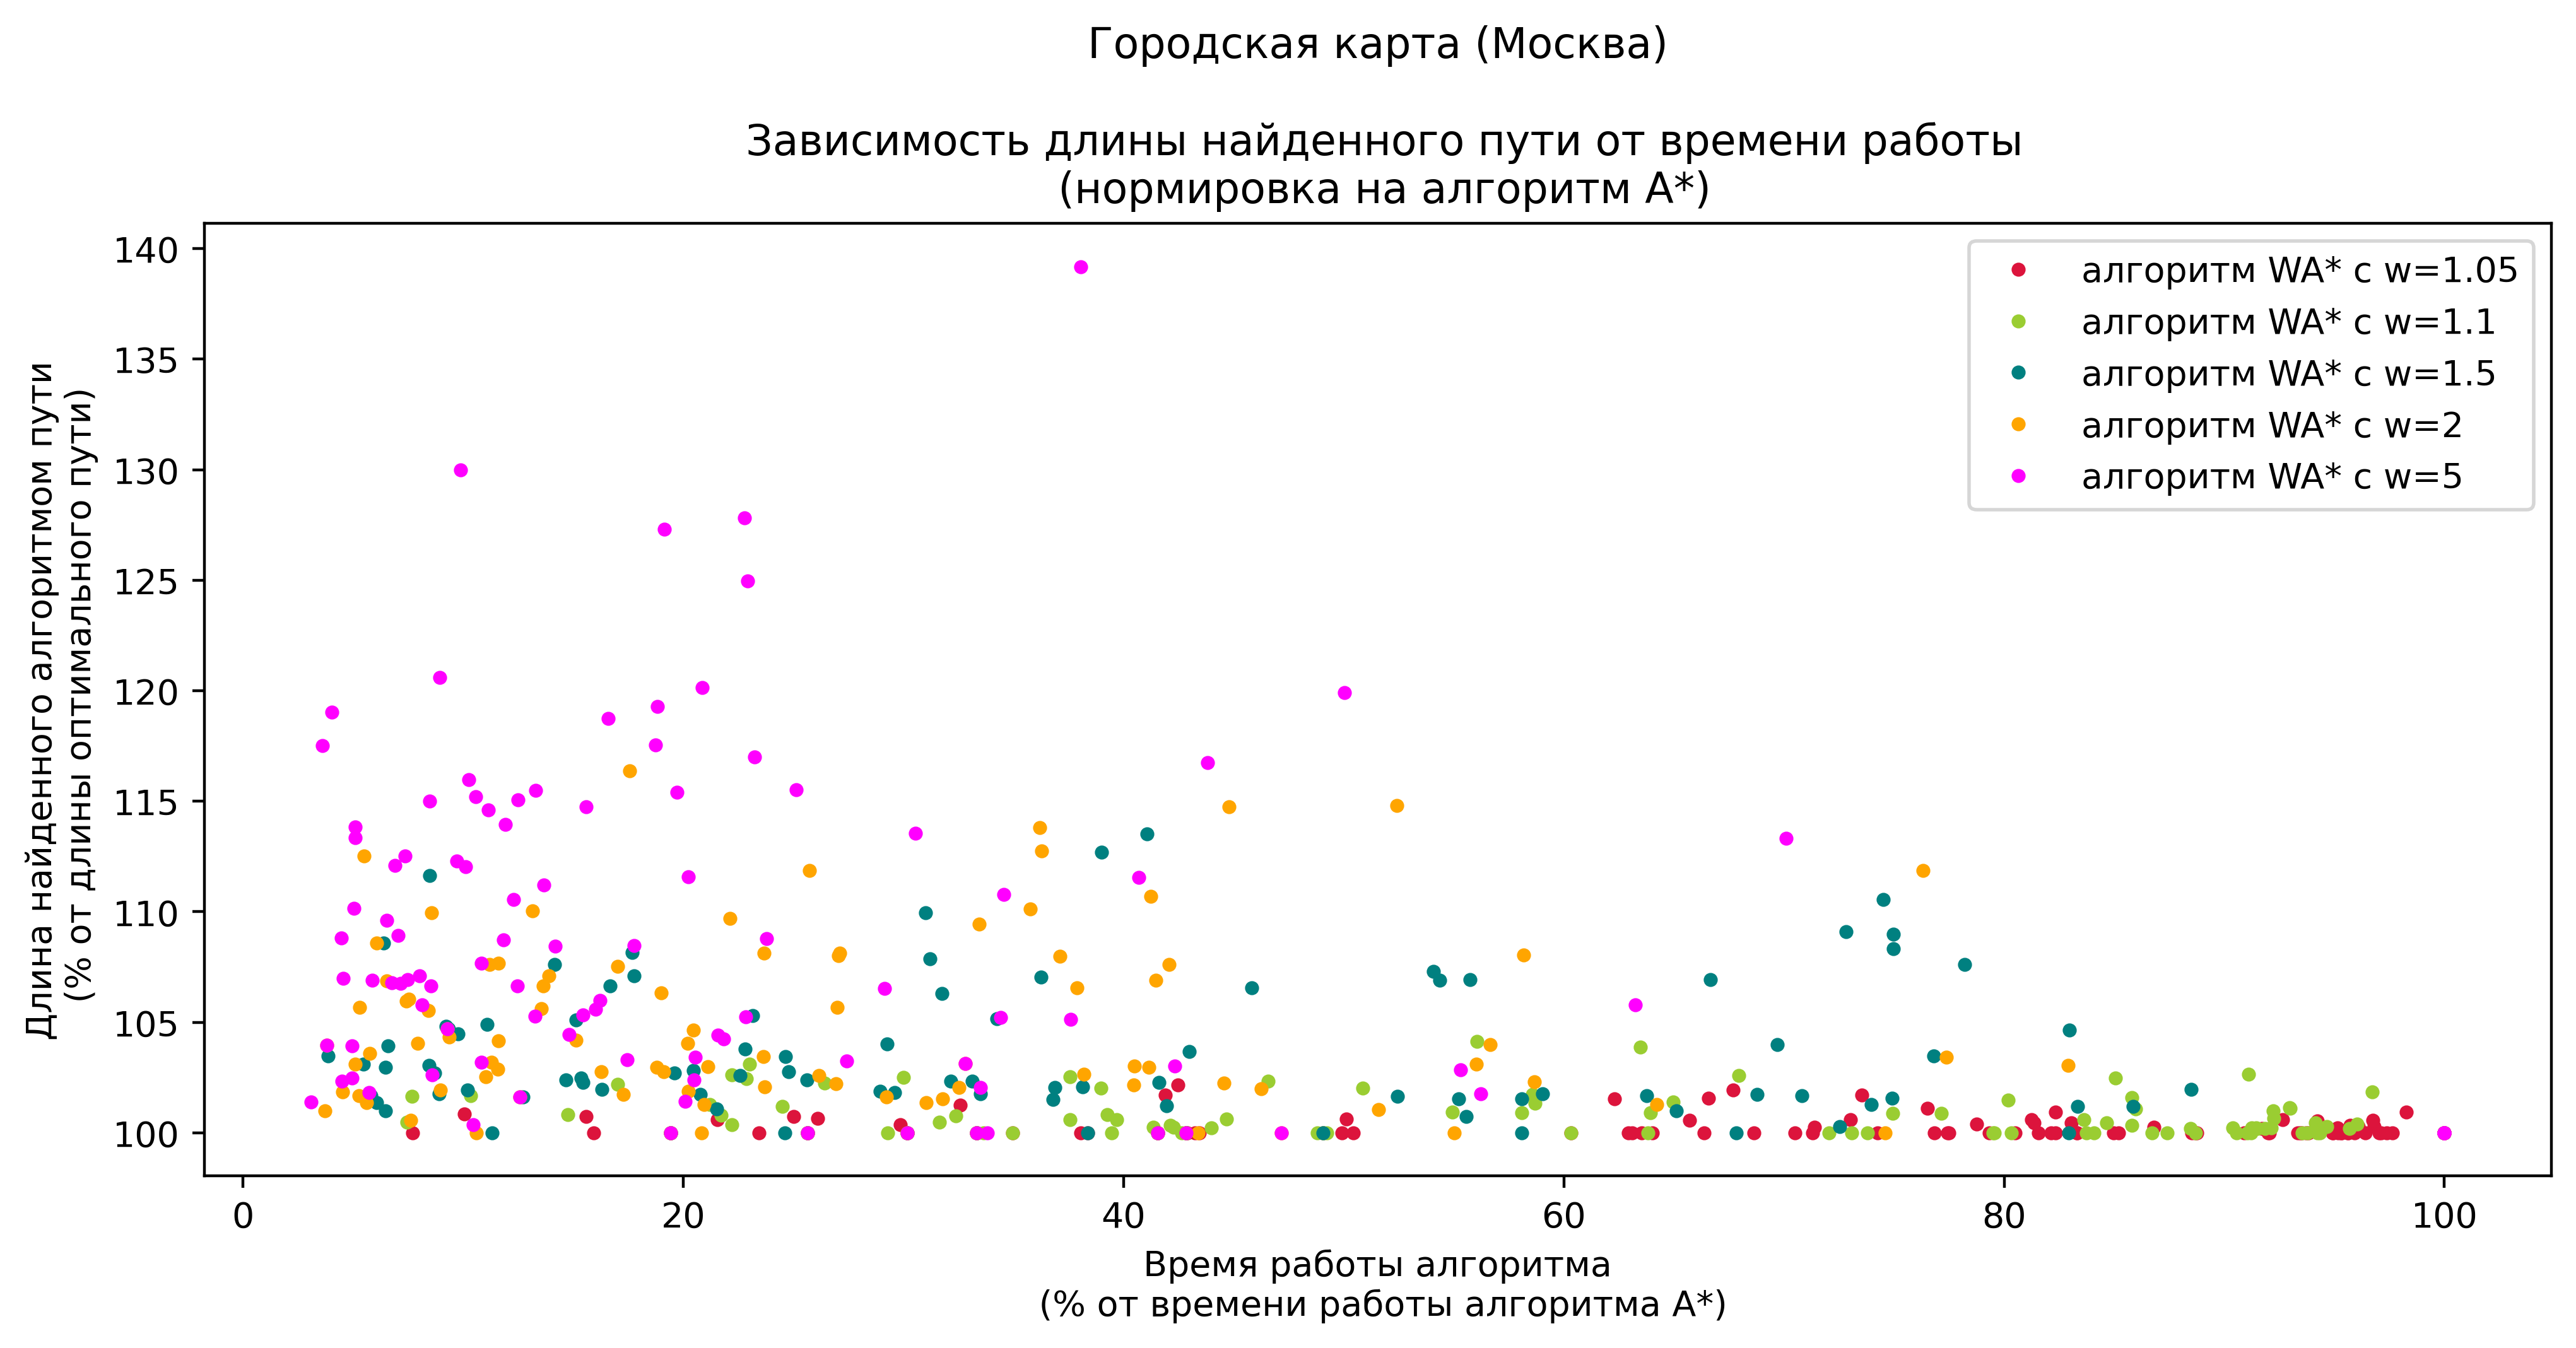

In [127]:
_, ax = plt.subplots(figsize=(12, 5), dpi=400)
ax.set_title("Городская карта (Москва)\n\n Зависимость длины найденного пути от времени работы\n (нормировка на алгоритм A*)")
ax.set_ylabel("Длина найденного алгоритмом пути\n (% от длины оптимального пути)")
ax.set_xlabel("Время работы алгоритма\n (% от времени работы алгоритма A*)")

shift = 0.2
index = np.arange(4)


plt1 = plt.plot(WA_w105_steps[0] / A_steps[0] * 100,  # нормируем число шагов (что мы считаем за меру времени работы алгоритма - очевидно, они коррелируют) алгоритма WA* с w=1.05 на число шагов A* - и домножаем на 100 - получаем процент от числа шагов WA*
        WA_w105_find_length[0] / A_find_length[0] * 100,  # аналогично получаем процент от длины пути, найденного A* (так как A* всегда находит оптимальный, путь, то это то же самое, что процент длины оптимального пути)
        marker='.', color="crimson", linestyle="")
plt2 = plt.plot(WA_w110_steps[0] / A_steps[0] * 100,
        WA_w110_find_length[0] / A_find_length[0] * 100,
        marker='.', color="yellowgreen", linestyle="", label="алгоритм WA* с w=" + str(1.10))
plt3 = plt.plot(WA_w150_steps[0] / A_steps[0] * 100,
        WA_w150_find_length[0] / A_find_length[0] * 100,
        marker='.', color="teal", linestyle="", label="алгоритм WA* с w=" + str(1.50))
plt4 = plt.plot(WA_w200_steps[0] / A_steps[0] * 100,
        WA_w200_find_length[0] / A_find_length[0] * 100,
        marker='.', color="orange", linestyle="", label="алгоритм WA* с w=" + str(2.00))
plt5 = plt.plot(WA_w500_steps[0] / A_steps[0] * 100,
        WA_w500_find_length[0] / A_find_length[0] * 100,
        marker='.', color="magenta", linestyle="", label="алгоритм WA* с w=" + str(5.00))

plt.legend([plt1[0], plt2[0], plt3[0], plt4[0], plt5[0]],
            ["алгоритм WA* с w=" + str(1.05), "алгоритм WA* с w=" + str(1.1), "алгоритм WA* с w=" + str(1.5),
            "алгоритм WA* с w=" + str(2), "алгоритм WA* с w=" + str(5)])
# plt.savefig("msc_WA.png", transparent=False, bbox_inches="tight", facecolor='white')
plt.show()

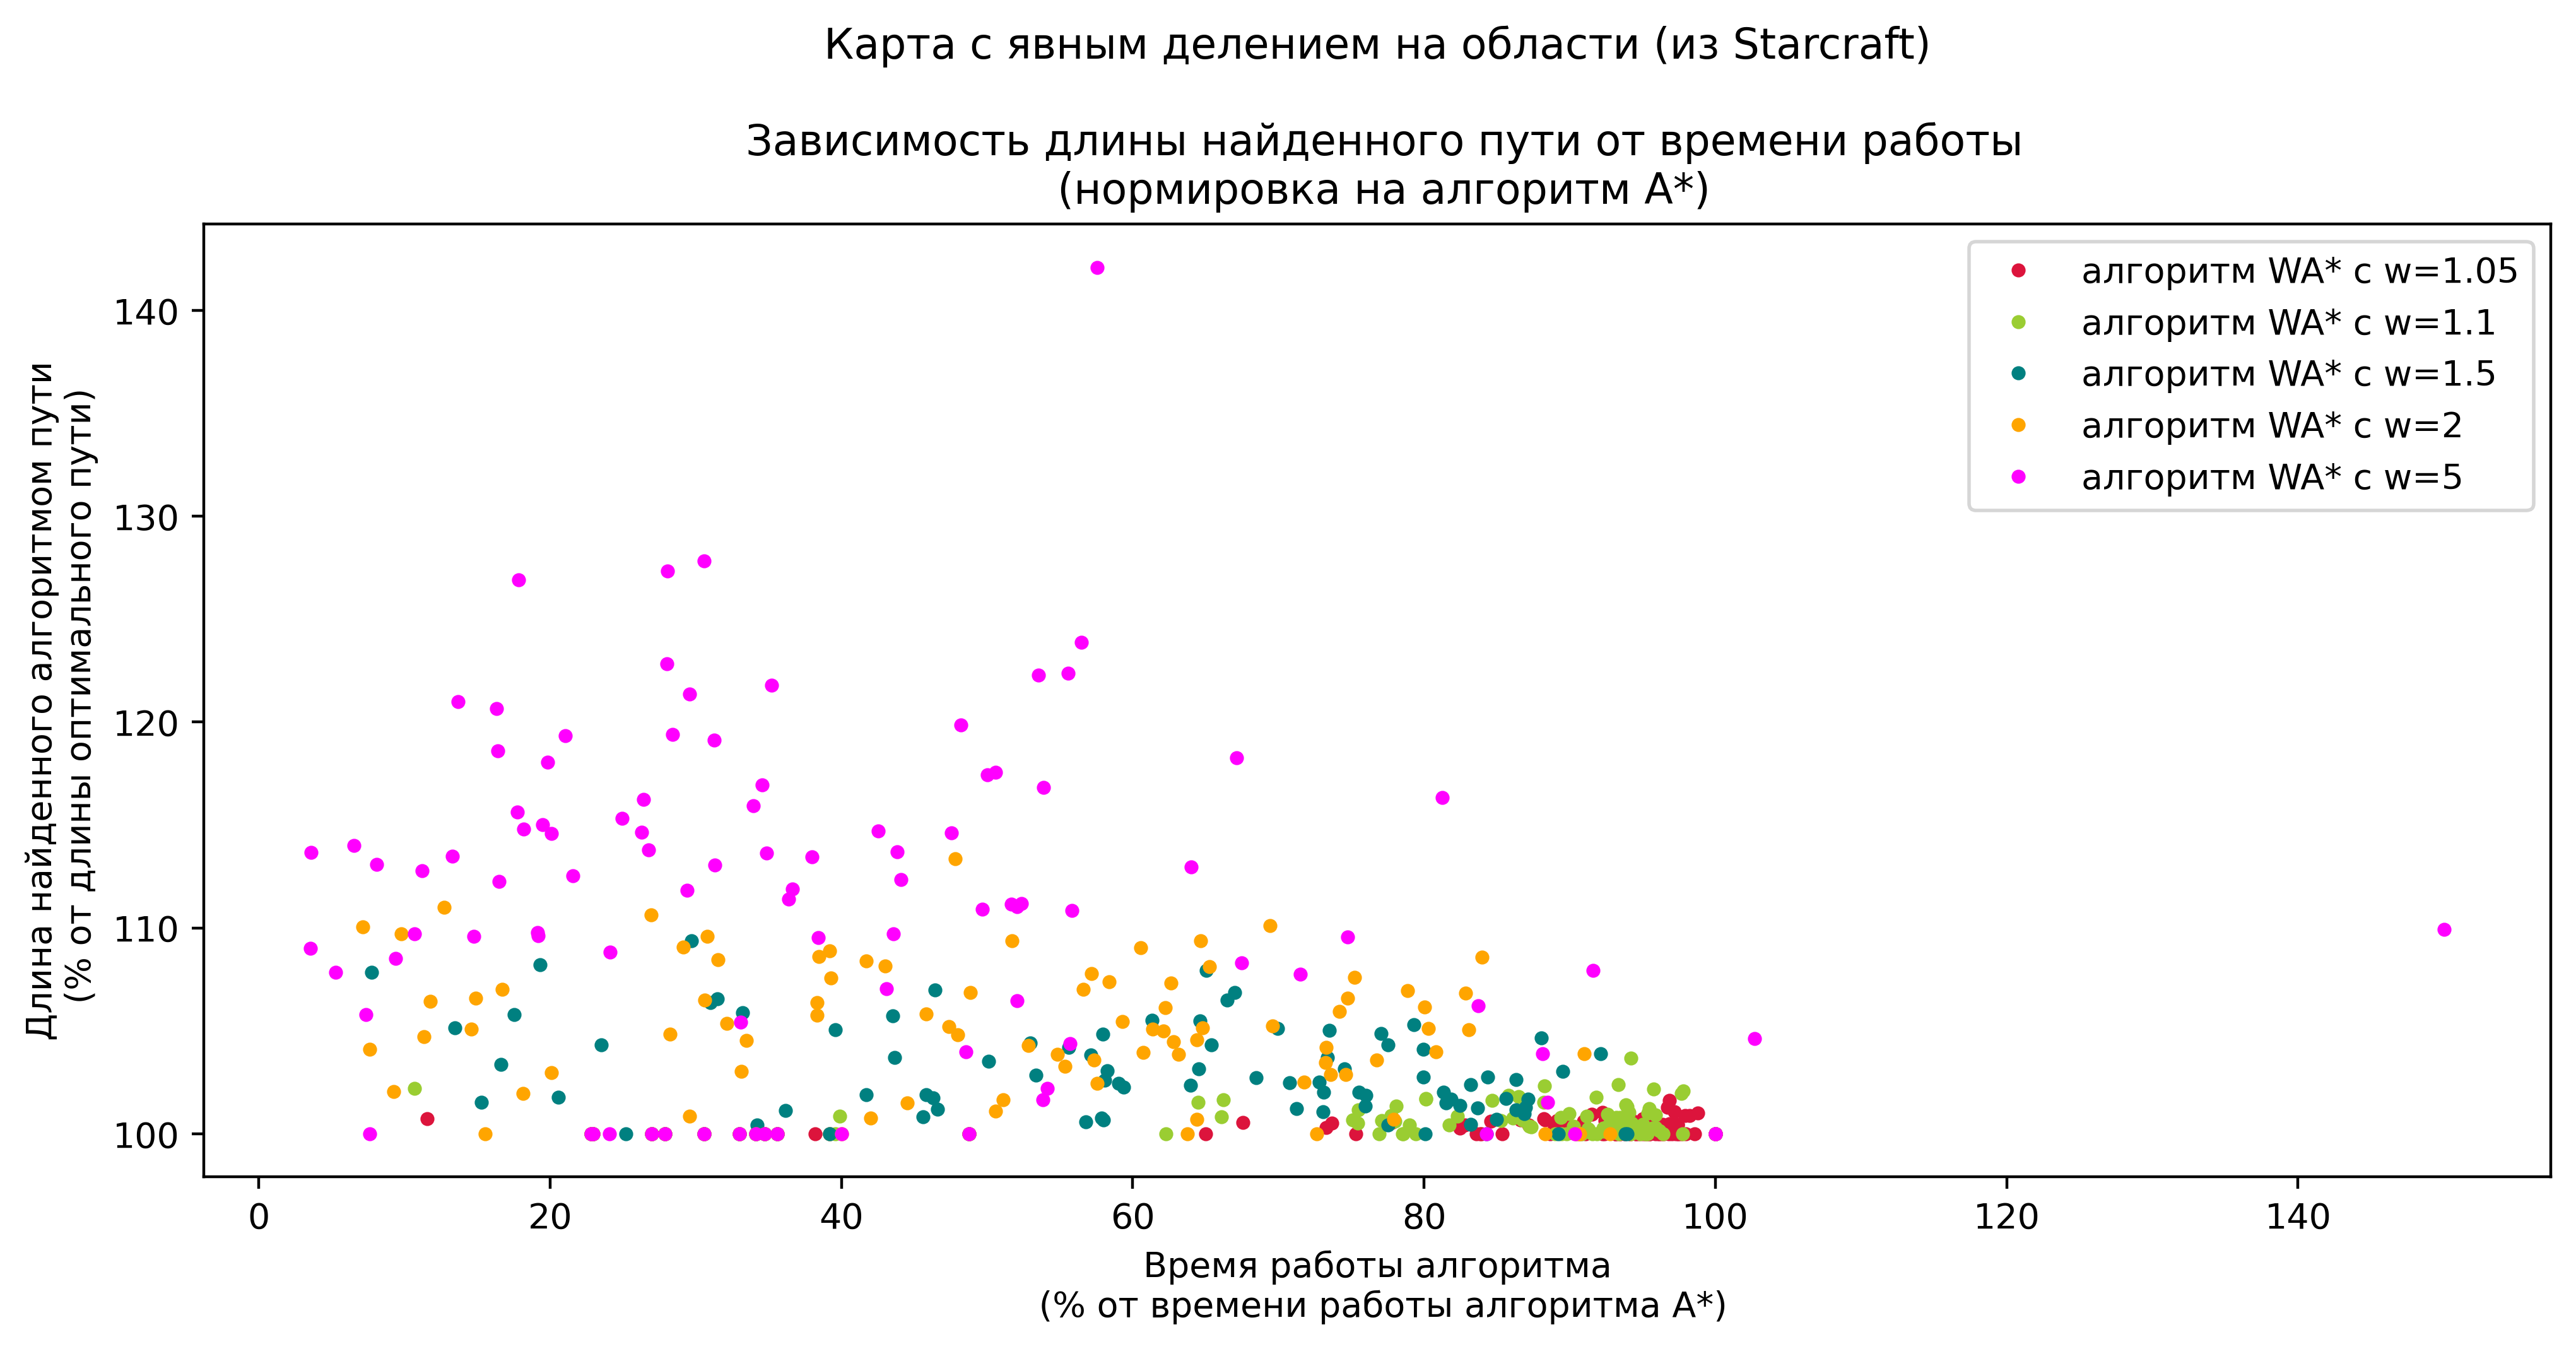

In [128]:
_, ax = plt.subplots(figsize=(12, 5), dpi=400)
ax.set_title("Карта с явным делением на области (из Starcraft)\n\n Зависимость длины найденного пути от времени работы\n (нормировка на алгоритм A*)")
ax.set_ylabel("Длина найденного алгоритмом пути\n (% от длины оптимального пути)")
ax.set_xlabel("Время работы алгоритма\n (% от времени работы алгоритма A*)")

shift = 0.2
index = np.arange(4)


plt1 = plt.plot(WA_w105_steps[1] / A_steps[1] * 100,
        WA_w105_find_length[1] / A_find_length[1] * 100,
        marker='.', color="crimson", linestyle="")
plt2 = plt.plot(WA_w110_steps[1] / A_steps[1] * 100,
        WA_w110_find_length[1] / A_find_length[1] * 100,
        marker='.', color="yellowgreen", linestyle="", label="алгоритм WA* с w=" + str(1.10))
plt3 = plt.plot(WA_w150_steps[1] / A_steps[1] * 100,
        WA_w150_find_length[1] / A_find_length[1] * 100,
        marker='.', color="teal", linestyle="", label="алгоритм WA* с w=" + str(1.50))
plt4 = plt.plot(WA_w200_steps[1] / A_steps[1] * 100,
        WA_w200_find_length[1] / A_find_length[1] * 100,
        marker='.', color="orange", linestyle="", label="алгоритм WA* с w=" + str(2.00))
plt5 = plt.plot(WA_w500_steps[1] / A_steps[1] * 100,
        WA_w500_find_length[1] / A_find_length[1] * 100,
        marker='.', color="magenta", linestyle="", label="алгоритм WA* с w=" + str(5.00))

plt.legend([plt1[0], plt2[0], plt3[0], plt4[0], plt5[0]],
            ["алгоритм WA* с w=" + str(1.05), "алгоритм WA* с w=" + str(1.1), "алгоритм WA* с w=" + str(1.5),
            "алгоритм WA* с w=" + str(2), "алгоритм WA* с w=" + str(5)])
# plt.savefig("starcraft_WA.png", transparent=False, bbox_inches="tight", facecolor='white')
plt.show()

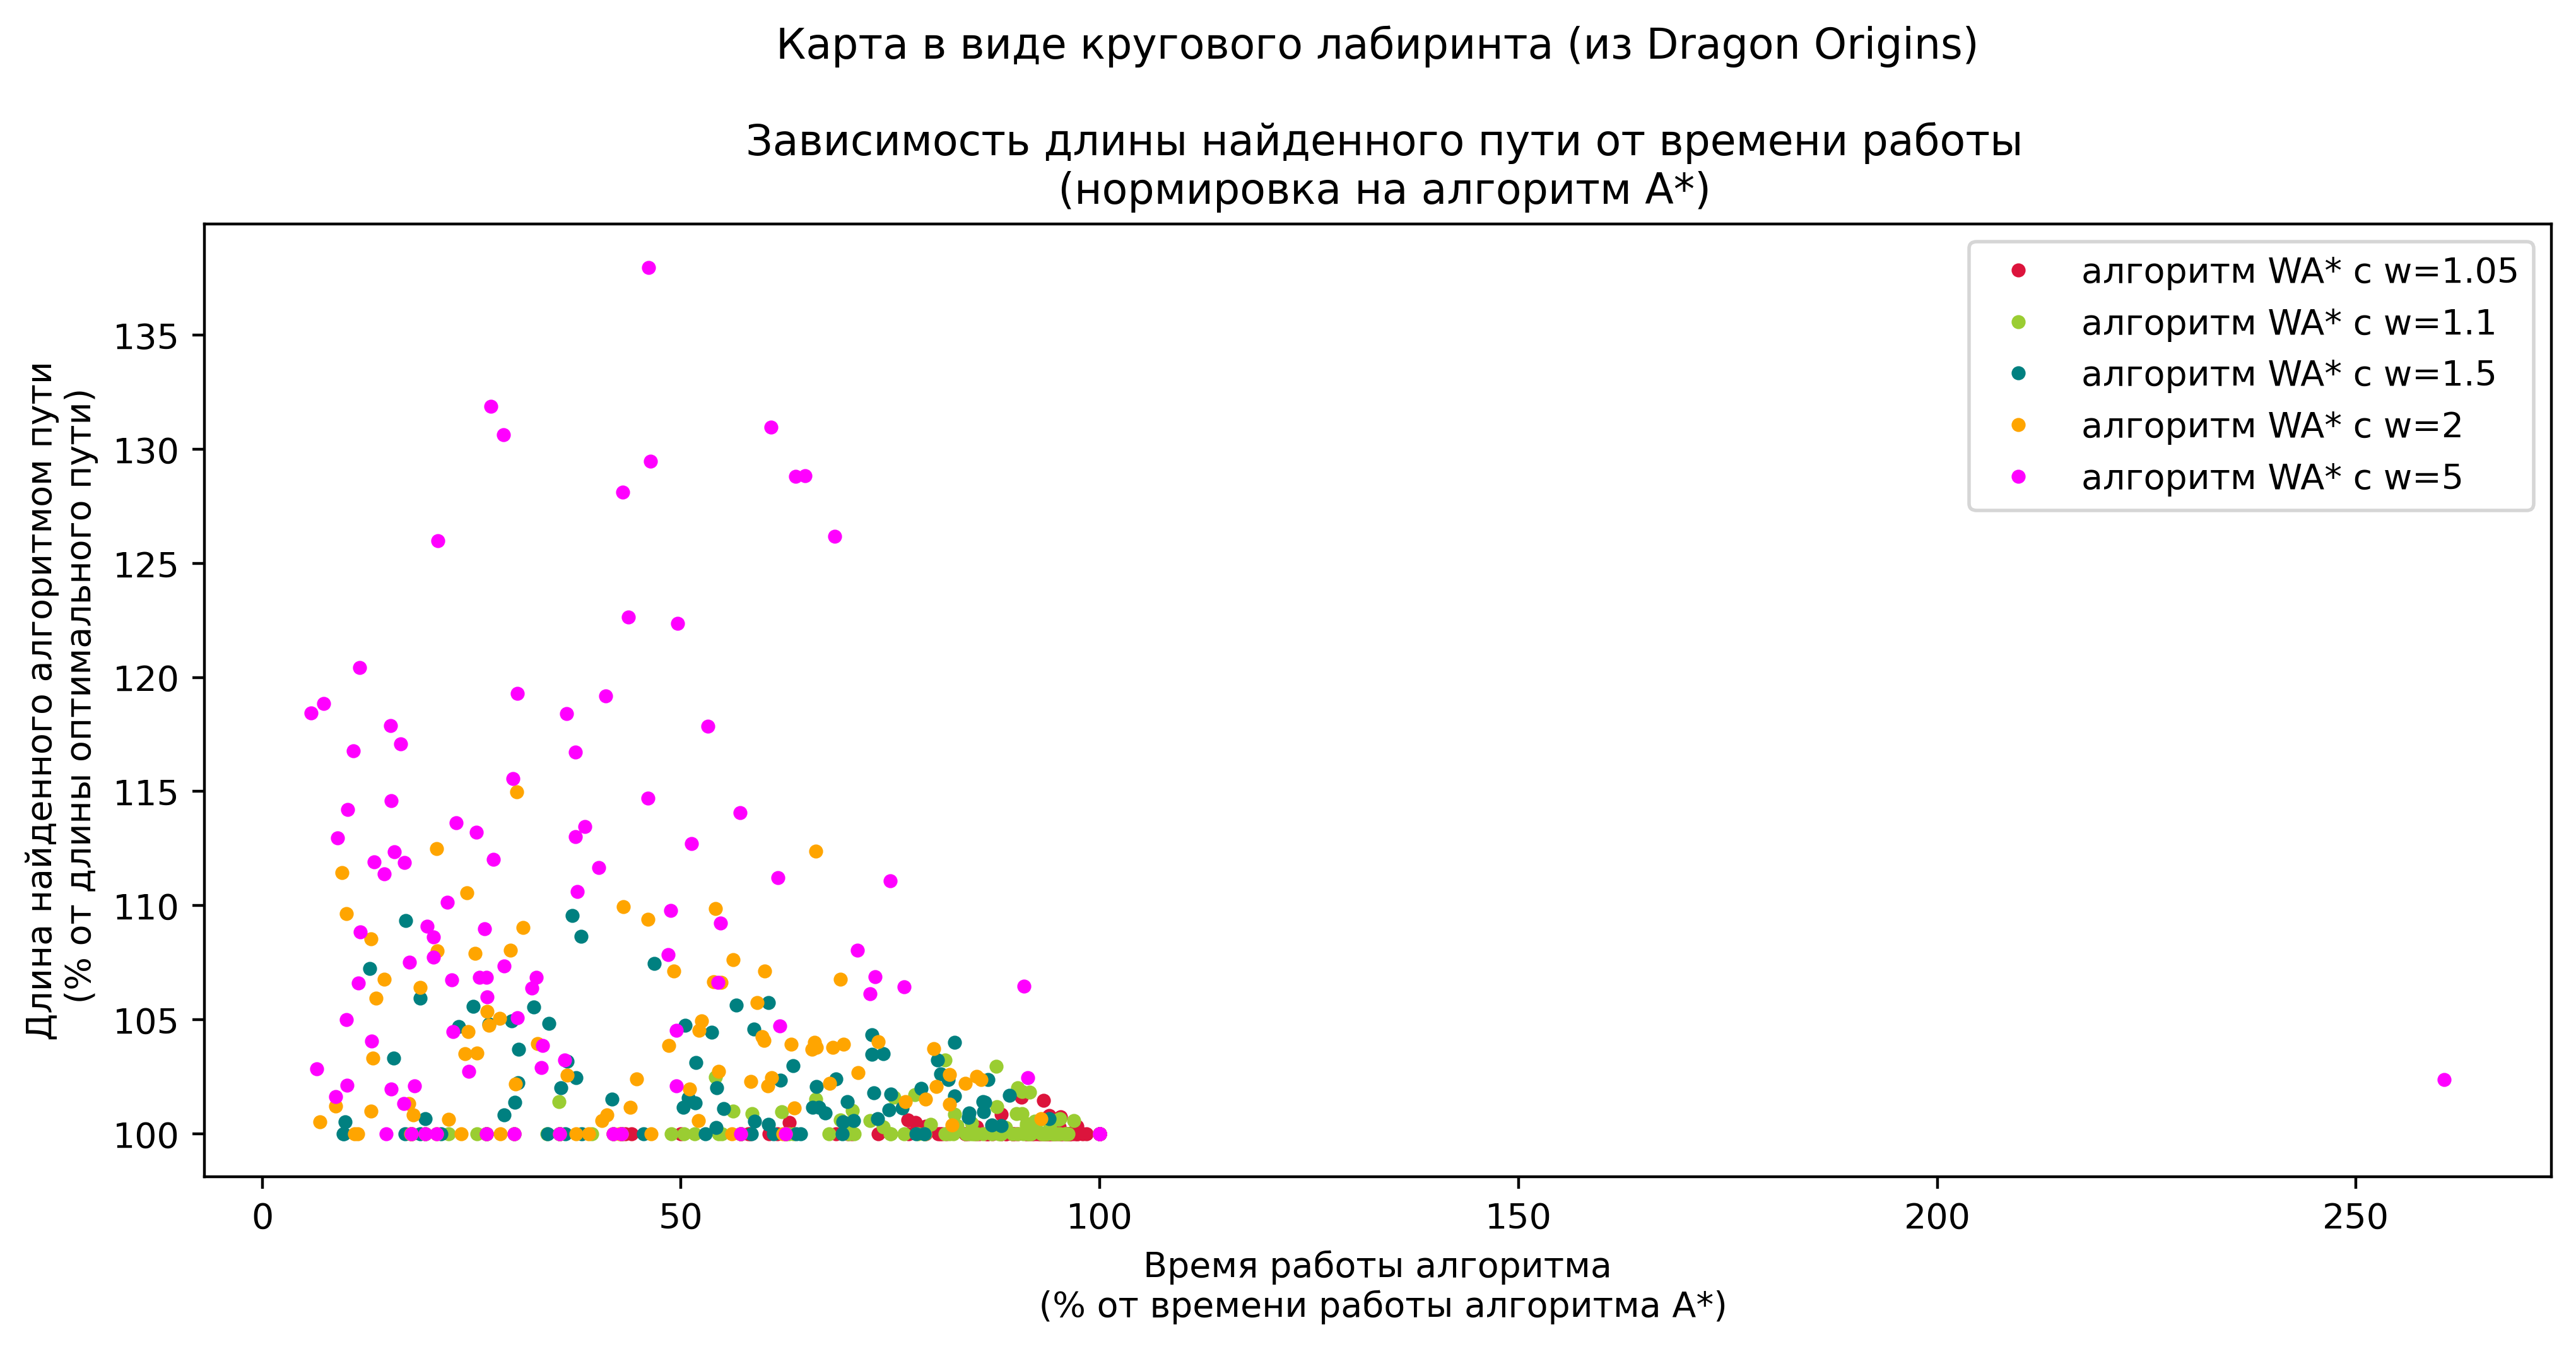

In [129]:
_, ax = plt.subplots(figsize=(12, 5), dpi=400)
ax.set_title("Карта в виде кругового лабиринта (из Dragon Origins)\n\n Зависимость длины найденного пути от времени работы\n (нормировка на алгоритм A*)")
ax.set_ylabel("Длина найденного алгоритмом пути\n (% от длины оптимального пути)")
ax.set_xlabel("Время работы алгоритма\n (% от времени работы алгоритма A*)")

shift = 0.2
index = np.arange(4)


plt1 = plt.plot(WA_w105_steps[2] / A_steps[2] * 100,
        WA_w105_find_length[2] / A_find_length[2] * 100,
        marker='.', color="crimson", linestyle="")
plt2 = plt.plot(WA_w110_steps[2] / A_steps[2] * 100,
        WA_w110_find_length[2] / A_find_length[2] * 100,
        marker='.', color="yellowgreen", linestyle="", label="алгоритм WA* с w=" + str(1.10))
plt3 = plt.plot(WA_w150_steps[2] / A_steps[2] * 100,
        WA_w150_find_length[2] / A_find_length[2] * 100,
        marker='.', color="teal", linestyle="", label="алгоритм WA* с w=" + str(1.50))
plt4 = plt.plot(WA_w200_steps[2] / A_steps[2] * 100,
        WA_w200_find_length[2] / A_find_length[2] * 100,
        marker='.', color="orange", linestyle="", label="алгоритм WA* с w=" + str(2.00))
plt5 = plt.plot(WA_w500_steps[2] / A_steps[2] * 100,
        WA_w500_find_length[2] / A_find_length[2] * 100,
        marker='.', color="magenta", linestyle="", label="алгоритм WA* с w=" + str(5.00))

plt.legend([plt1[0], plt2[0], plt3[0], plt4[0], plt5[0]],
            ["алгоритм WA* с w=" + str(1.05), "алгоритм WA* с w=" + str(1.1), "алгоритм WA* с w=" + str(1.5),
            "алгоритм WA* с w=" + str(2), "алгоритм WA* с w=" + str(5)])
# plt.savefig("dragon_WA.png", transparent=False, bbox_inches="tight", facecolor='white')
plt.show()

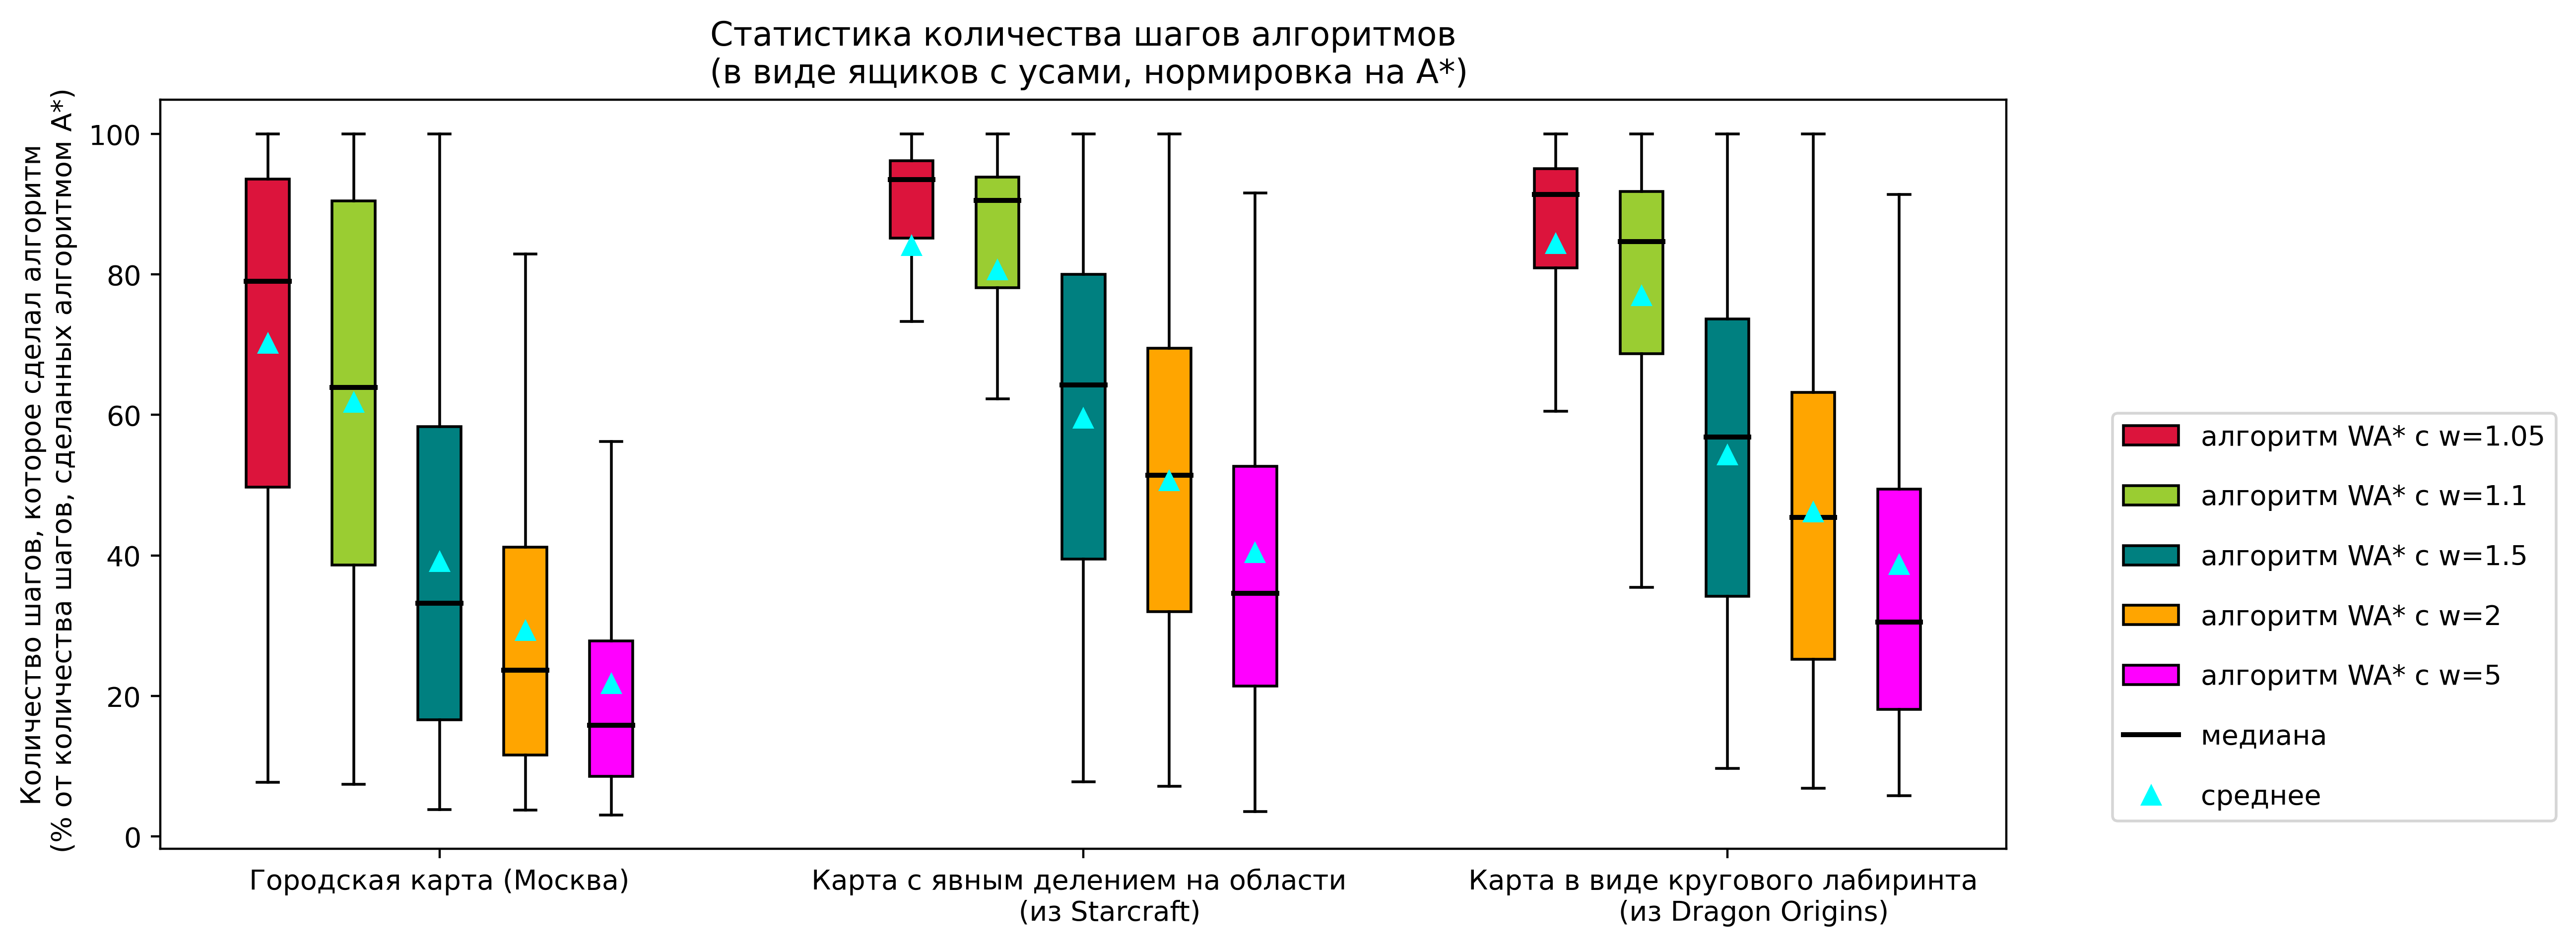

In [130]:
_, ax = plt.subplots(figsize=(12, 5), dpi=400)
ax.set_title("Статистика количества шагов алгоритмов\n (в виде ящиков с усами, нормировка на A*)")
ax.set_ylabel("Количество шагов, которое сделал алгоритм\n (% от количества шагов, сделанных алгоритмом A*)")

shift = 0.4  # сдвиг
index = 3 * np.arange(3)  # положение трех ящиков на оси x (мы 5 раз рисуем по три ящика в каждом из boxes_i - вот в кажом boxes_i положения этих трёх ящиков задаются index)

boxes1 = plt.boxplot((WA_w105_steps[0] / A_steps[0] * 100, 
                      WA_w105_steps[1] / A_steps[1] * 100, 
                      WA_w105_steps[2] / A_steps[2] * 100), 
            showmeans=True, patch_artist=True, boxprops=dict(facecolor="crimson"),
            widths=shift / 2, positions=index, showfliers=False,
            medianprops=dict(linewidth=1.8, color="black"),
            meanprops=dict(markeredgewidth=0, markerfacecolor="cyan", markersize=8))

boxes2 = plt.boxplot((WA_w110_steps[0] / A_steps[0] * 100, 
                      WA_w110_steps[1] / A_steps[1] * 100, 
                      WA_w110_steps[2] / A_steps[2] * 100), 
            showmeans=True, patch_artist=True, boxprops=dict(facecolor="yellowgreen"),
            widths=shift / 2, positions=index + 1 * shift, showfliers=False,
            medianprops=dict(linewidth=1.8, color="black"),
            meanprops=dict(markeredgewidth=0, markerfacecolor="cyan", markersize=8))

boxes3 = plt.boxplot((WA_w150_steps[0] / A_steps[0] * 100, 
                      WA_w150_steps[1] / A_steps[1] * 100, 
                      WA_w150_steps[2] / A_steps[2] * 100), 
            showmeans=True, patch_artist=True, boxprops=dict(facecolor="teal"),
            widths=shift / 2, positions=index + 2 * shift, showfliers=False,
            medianprops=dict(linewidth=1.8, color="black"),
            meanprops=dict(markeredgewidth=0, markerfacecolor="cyan", markersize=8))

boxes4 = plt.boxplot((WA_w200_steps[0] / A_steps[0] * 100, 
                      WA_w200_steps[1] / A_steps[1] * 100, 
                      WA_w200_steps[2] / A_steps[2] * 100), 
            showmeans=True, patch_artist=True, boxprops=dict(facecolor="orange"),
            widths=shift / 2, positions=index + 3 * shift, showfliers=False,
            medianprops=dict(linewidth=1.8, color="black"),
            meanprops=dict(markeredgewidth=0, markerfacecolor="cyan", markersize=8))

boxes5 = plt.boxplot((WA_w500_steps[0] / A_steps[0] * 100, 
                      WA_w500_steps[1] / A_steps[1] * 100, 
                      WA_w500_steps[2] / A_steps[2] * 100), 
            showmeans=True, patch_artist=True, boxprops=dict(facecolor="magenta"),
            widths=shift / 2, positions=index + 4 * shift, showfliers=False,
            medianprops=dict(linewidth=1.8, color="black"),
            meanprops=dict(markeredgewidth=0, markerfacecolor="cyan", markersize=8))


plt.xticks(index + 2 * shift, ["Городская карта (Москва)", "Карта с явным делением на области \n      (из Starcraft)",
                           "Карта в виде кругового лабиринта \n      (из Dragon Origins)"])
plt.legend([boxes1["boxes"][0], boxes2["boxes"][0], boxes3["boxes"][0], boxes4["boxes"][0], boxes5["boxes"][0],
            boxes1["medians"][0], boxes1["means"][0]],
           ["алгоритм WA* с w=" + str(1.05), "алгоритм WA* с w=" + str(1.1), "алгоритм WA* с w=" + str(1.5),
            "алгоритм WA* с w=" + str(2), "алгоритм WA* с w=" + str(5), "медиана", "среднее"],
            bbox_to_anchor = (1.05, 0.6), labelspacing=1.2)
# plt.savefig("boxplot_WA.png", transparent=False, bbox_inches="tight", facecolor='white')  # сохраняем всю картинку (transparent=False - чтобы фон самой диаграммы не был прозрачен, facecolor='white' - чтобы фон, где надписи был белым а не тусклым, bbox_inches="tight" - чтобы сохранялось все то, что выводится (а не обрезанный кусок))
plt.show()